C:\Users\jobm3\AppData\Local\Temp\ipykernel_27776\2465960218.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


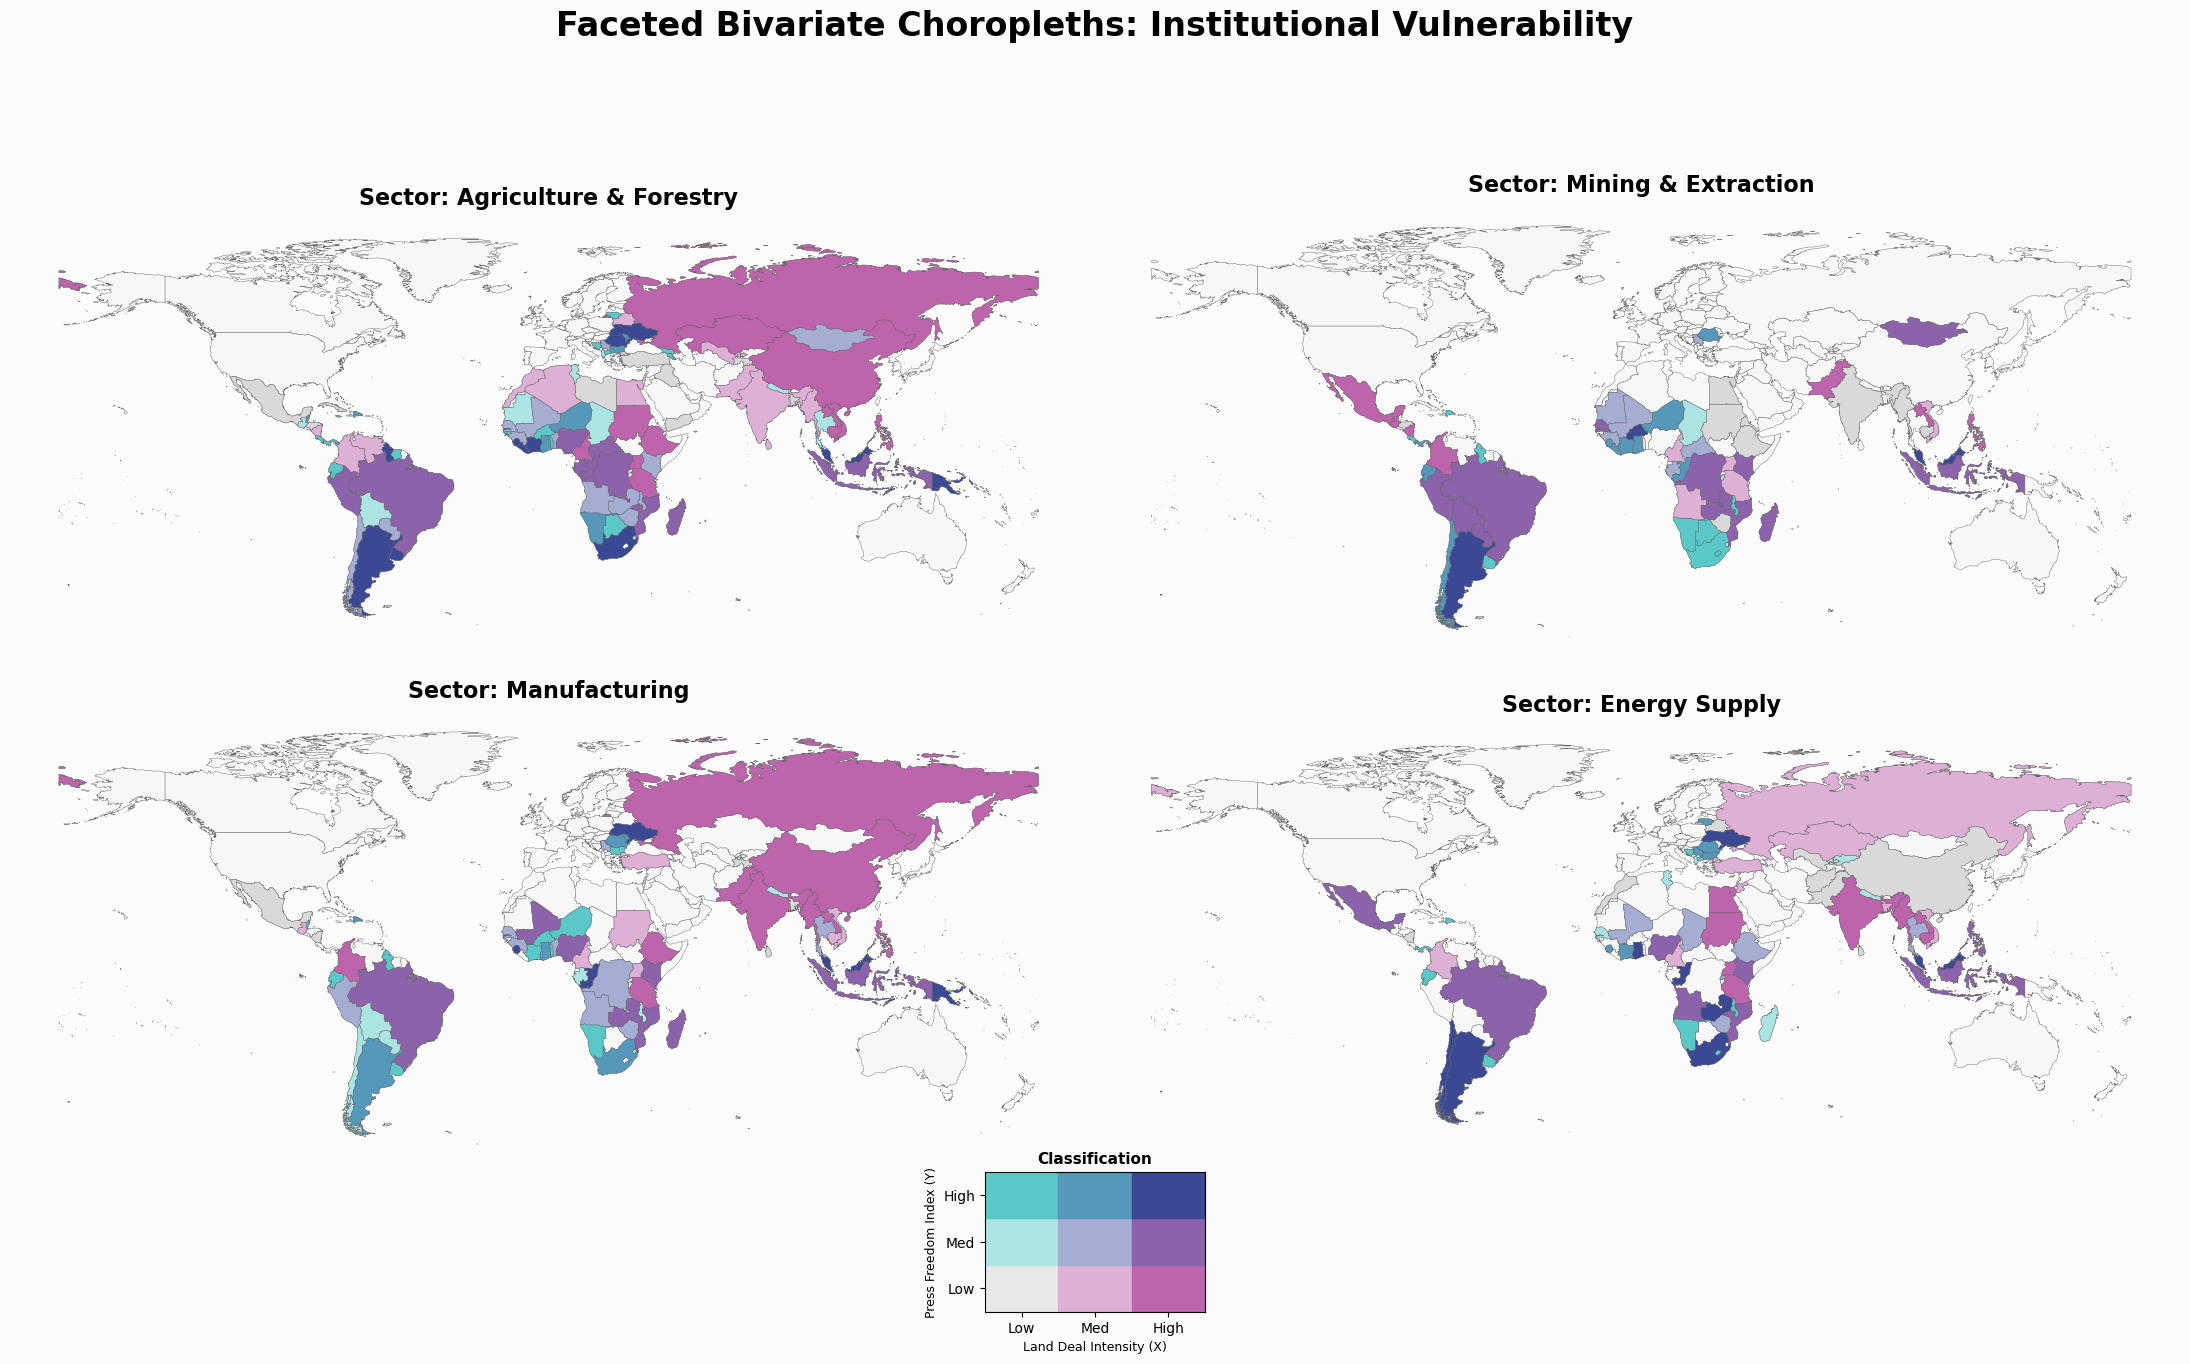

In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Load the World Map (using your specific source and cleaning)
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)

# Rename and filter as requested
world = world.rename(columns={
    "ADMIN": "country",
    "ADM0_A3": "iso3",   # The join key
    "SOV_A3": "sov_iso3"
})[["country", "iso3", "sov_iso3", "geometry"]]

# Remove Antarctica for better visualization
world = world[world["country"] != "Antarctica"]

# 2. Load and Clean Datasets
land = pd.read_csv('landmatrix_final_analytical_dataset.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# Standardize ISO codes to match 'world.iso3'
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# 3. Define Analysis Parameters
sectors = {
    'sector_A': 'Agriculture & Forestry',
    'sector_B': 'Mining & Extraction',
    'sector_C': 'Manufacturing',
    'sector_D': 'Energy Supply'
}

# Bivariate Palette (Low/Low: Gray -> High/High: Dark Blue)
# Vulnerability (High Land/Low Freedom) is the Pink/Magenta zone
biv_colors = [
    '#e8e8e8', '#ace4e4', '#5ac8c8', # Low Land Intensity (Across Y)
    '#dfb0d6', '#a5add3', '#5698b9', # Med Land Intensity (Across Y)
    '#be64ac', '#8c62aa', '#3b4994'  # High Land Intensity (Across Y)
]

def get_bivariate_class(df, x_col, y_col):
    """Calculates the 1-9 class for bivariate mapping."""
    # Remove NaNs to calculate quantiles accurately
    df = df.dropna(subset=[x_col, y_col]).copy()
    if len(df) < 3: return df
    
    # 3x3 Bins: x_bin (Land Intensity), y_bin (Press Freedom)
    # Using 'Int64' to allow for any remaining NaNs in the final merge
    df['x_bin'] = pd.qcut(df[x_col].rank(method='first'), 3, labels=[1, 2, 3]).astype('Int64')
    df['y_bin'] = pd.qcut(df[y_col].rank(method='first'), 3, labels=[1, 2, 3]).astype('Int64')
    
    # Combined index (1-9)
    df['bi_class'] = (df['x_bin'] - 1) * 3 + df['y_bin']
    return df

# 4. Generate Plot
fig, axes = plt.subplots(2, 2, figsize=(22, 14), facecolor='#fbfbfb')
axes = axes.flatten()

for i, (sec_col, sec_label) in enumerate(sectors.items()):
    ax = axes[i]
    
    # 1. Aggregate and process data for this sector
    sec_land = land[land[sec_col] == 1].groupby('iso3')['Deal size'].sum().reset_index()
    sec_land.columns = ['iso3', 'intensity']
    merged_data = pd.merge(sec_land, indep[['iso3', 'Press_Freedom_Score']], on='iso3', how='inner')
    bivariate_df = get_bivariate_class(merged_data, 'intensity', 'Press_Freedom_Score')
    
    # 2. Join with the World geometry
    map_df = world.merge(bivariate_df, on='iso3', how='left')
    
    # 3. PLOT BASE LAYER (This ensures all countries are visible even if they have no data)
    # Using a darker edge color (#636363) makes the white/gray countries visible
    world.plot(ax=ax, color='#f7f7f7', edgecolor='#636363', linewidth=0.3)
    
    # 4. PLOT BIVARIATE CLASSES (With outlines)
    # I darkened the first color slightly from #e8e8e8 to #d9d9d9 for better visibility
    refined_colors = biv_colors.copy()
    refined_colors[0] = '#d9d9d9' 
    
    for val in range(1, 10):
        subset = map_df[map_df['bi_class'] == val]
        if not subset.empty:
            subset.plot(
                ax=ax, 
                color=refined_colors[val-1], 
                edgecolor='#636363', # Darker gray outline for clarity
                linewidth=0.3
            )
            
    ax.set_title(f"Sector: {sec_label}", fontsize=16, fontweight='bold', pad=10)
    ax.axis('off')

# 5. Add Bivariate Legend
leg_ax = fig.add_axes([0.45, 0.05, 0.1, 0.1]) # Manual placement
for x in range(3):
    for y in range(3):
        leg_ax.add_patch(plt.Rectangle((x, y), 1, 1, color=biv_colors[x*3 + y]))

leg_ax.set_xlim(0, 3); leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'])
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'])
leg_ax.set_xlabel('Land Deal Intensity (X)', fontsize=9)
leg_ax.set_ylabel('Press Freedom Index (Y)', fontsize=9)
leg_ax.set_title('Classification', fontsize=11, fontweight='bold')

plt.suptitle("Faceted Bivariate Choropleths: Institutional Vulnerability", 
             fontsize=24, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

In [10]:
import pandas as pd
import numpy as np

# 1. Load the primary datasets
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
land = pd.read_csv('landmatrix_final_analytical_dataset.csv')
climate = pd.read_csv('climate_litigation_final_unified.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# 2. Standardize ISO3 Country Codes for merging and analysis
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()
climate['iso3'] = climate['Geographies'].str.split(';').str[0].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# 3. Sector Mapping (NACE Taxonomy)
sector_map = {
    'sector_A': 'Agriculture, Forestry & Fishing',
    'sector_B': 'Mining & Quarrying',
    'sector_C': 'Manufacturing',
    'sector_D': 'Energy (Electricity/Gas) Supply',
    'sector_E': 'Water & Waste Management',
    'sector_F': 'Construction',
    'sector_G': 'Trade & Vehicle Repair',
    'sector_H': 'Transportation & Storage',
    'sector_I': 'Accommodation & Food Service',
    'sector_J': 'Information & Communication',
    'sector_K': 'Financial & Insurance',
    'sector_L': 'Real Estate Activities',
    'sector_M': 'Professional & Technical',
    'sector_N': 'Administrative Services',
    'sector_O': 'Public Admin & Defence'
}

def print_section(title):
    print(f"\n{'='*75}\n{title}\n{'='*75}")

# --- SECTION 1: DATASET OVERVIEW ---
print_section("DATASET OVERVIEW & COUNTRY COVERAGE")
datasets_dict = {
    "ISDS (Disputes)": isds,
    "Land Matrix (Deals)": land,
    "Climate (Litigation)": climate,
    "Indep Vars (Governance)": indep
}
for name, df in datasets_dict.items():
    # Count based on standardized ISO column
    u_count = df['iso3'].nunique() if 'iso3' in df.columns else df['resp_iso3'].nunique()
    print(f"{name:<25}: {len(df):>6} rows | {u_count:>4} unique countries")

# --- SECTION 2: SECTOR DISTRIBUTION ---
print_section("SECTOR DISTRIBUTION (Full Names)")
sector_cols = list(sector_map.keys())
sector_stats = pd.DataFrame(index=sector_cols)
for name, df in {"ISDS": isds, "Land": land, "Climate": climate}.items():
    existing = [c for c in sector_cols if c in df.columns]
    sector_stats[name] = df[existing].sum()
sector_stats.index = sector_stats.index.map(sector_map)
print(sector_stats.fillna(0).astype(int))

# --- SECTION 3: ISDS DISPUTE PATTERNS ---
print_section("ISDS DISPUTE PATTERNS & CONCENTRATION")
resp_counts = isds['resp_iso3'].value_counts()
inv_counts = isds['inv_iso3'].value_counts()
print(f"Total ISDS Cases: {len(isds)}")
print(f"\nTOP 10 RESPONDENTS (Targets):")
print(resp_counts.head(10))
print(f"Concentration (Top 10 Targets): {(resp_counts.head(10).sum()/resp_counts.sum())*100:.1f}%")
print(f"\nTOP 10 INVESTOR HOME STATES (Sources):")
print(inv_counts.head(10))
print(f"Concentration (Top 10 Sources): {(inv_counts.head(10).sum()/inv_counts.sum())*100:.1f}%")

# --- SECTION 4: ISDS MONEY FLOW ---
print_section("ISDS MONEY FLOW (Financial Claims in MUSD)")
print(f"Global Total Claimed: ${isds['amount_claimed_musd'].sum():,.2f} Million USD")

# Money by Sector
sector_money = {sector_map[col]: isds[isds[col] == 1]['amount_claimed_musd'].sum() 
                for col in sector_map if col in isds.columns}
print("\nCLAIMS BY SECTOR:")
print(pd.Series(sector_money).sort_values(ascending=False).apply(lambda x: f"${x:,.2f} MUSD"))

# Money between country pairs
country_pairs = isds.groupby(['inv_iso3', 'resp_iso3']).agg({
    'amount_claimed_musd': 'sum', 
    'inv_iso3': 'count'
}).rename(columns={'inv_iso3': 'case_count'}).reset_index()

print("\nTOP 20 COUNTRY-TO-COUNTRY FLOWS (Investor State -> Respondent State):")
print(country_pairs.sort_values(by='amount_claimed_musd', ascending=False).head(20).to_string(
    index=False, formatters={'amount_claimed_musd': lambda x: f"${x:,.2f} MUSD"}
))

# --- SECTION 5: LAND GRAB INTENSITY ---
print_section("LAND GRAB INTENSITY (Top Countries by Hectares)")
print(land.groupby('iso3')['Deal size'].sum().sort_values(ascending=False).head(10).map('{:,.0f} hectares'.format))

# --- SECTION 6: GOVERNANCE INDICATOR COVERAGE ---
print_section("GOVERNANCE & ECONOMIC INDICATORS (Coverage)")
indicators = ['Corruption_Score', 'Press_Freedom_Score', 'Literacy_Rate_Pct', 'Rule_of_Law_Score_Pct']
print(indep[indicators].describe().loc[['count', 'mean', 'min', 'max']])

# --- SECTION 7: GOLDEN SAMPLE COUNTRIES ---
print_section("GOLDEN SAMPLE COUNTRIES (Present in All 4 Datasets)")
golden = (set(land['iso3'].dropna()) & 
          set(isds['resp_iso3'].dropna()) & 
          set(climate['iso3'].dropna()) & 
          set(indep['iso3'].dropna()))
print(f"Total: {len(golden)} countries")
print(", ".join(sorted(list(golden))))


DATASET OVERVIEW & COUNTRY COVERAGE
ISDS (Disputes)          :   1332 rows |  132 unique countries
Land Matrix (Deals)      :  15019 rows |  112 unique countries
Climate (Litigation)     :   1543 rows |   60 unique countries
Indep Vars (Governance)  :    191 rows |  190 unique countries

SECTOR DISTRIBUTION (Full Names)
                                 ISDS   Land  Climate
Agriculture, Forestry & Fishing    42  11318      851
Mining & Quarrying                213   1200      500
Manufacturing                     175   1682      500
Energy (Electricity/Gas) Supply   228   1286      500
Water & Waste Management           46      0      758
Construction                      154      0      500
Trade & Vehicle Repair             29      0      500
Transportation & Storage           63      0      500
Accommodation & Food Service       16    148        0
Information & Communication        96      0      500
Financial & Insurance             131      0      500
Real Estate Activities       

### EXPLORATORY DATA ANALYSIS

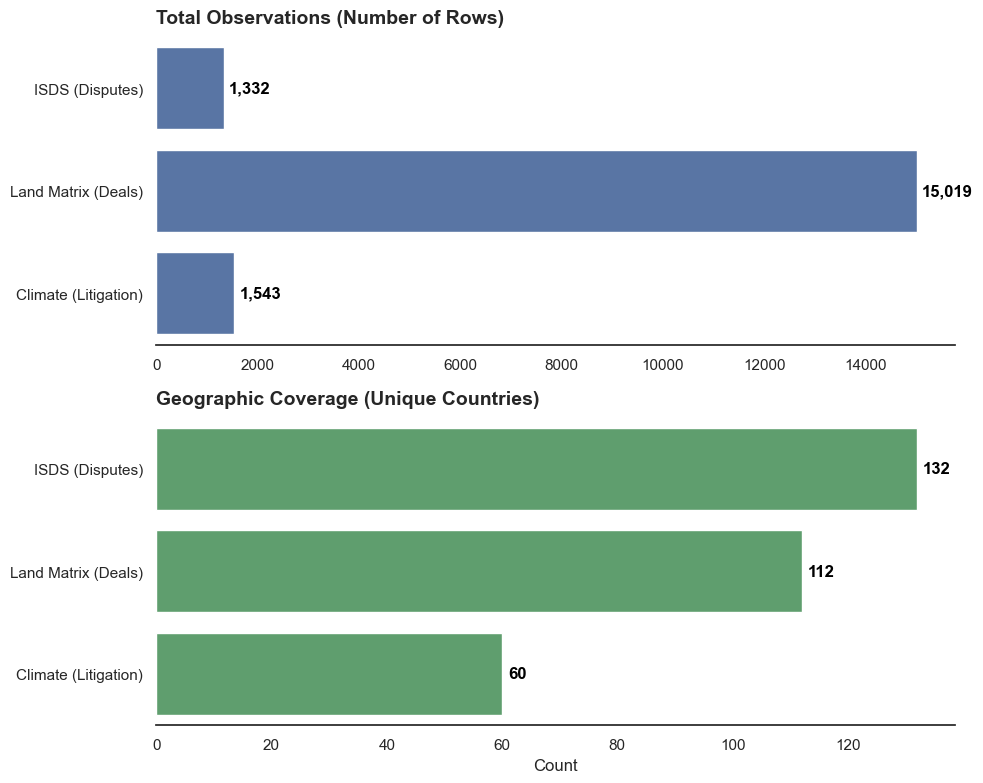

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the primary datasets
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
land = pd.read_csv('landmatrix_final_analytical_dataset.csv')
climate = pd.read_csv('climate_litigation_final_unified.csv')

# 2. Standardize ISO3 Country Codes for analysis
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()
# For climate, extract the primary country code from the Geographies field
climate['iso3'] = climate['Geographies'].str.split(';').str[0].str.strip().str.upper()

# 3. Calculate metrics directly from the data
rows_isds = len(isds)
countries_isds = isds['resp_iso3'].nunique()

rows_land = len(land)
countries_land = land['iso3'].nunique()

rows_climate = len(climate)
countries_climate = climate['iso3'].nunique()

# 4. Prepare the summary data for plotting
data = {
    'Dataset': ['ISDS (Disputes)', 'Land Matrix (Deals)', 'Climate (Litigation)'],
    'Rows': [rows_isds, rows_land, rows_climate],
    'Unique Countries': [countries_isds, countries_land, countries_climate]
}
df_stats = pd.DataFrame(data)

# 5. Design the plot using Lecture 03 principles (No Chart Junk, Clear Purpose)
sns.set_theme(style="white") # Clean background
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Subplot A: Total Observations (Number of Rows)
# Bars are kept in the original order for conceptual grouping, 
# or can be sorted by value if desired.
sns.barplot(x='Rows', y='Dataset', data=df_stats, ax=ax1, color='#4c72b0')
ax1.set_title('Total Observations (Number of Rows)', fontsize=14, fontweight='bold', loc='left', pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Add direct labeling (Tufte principle: reveal detail directly)
for i, v in enumerate(df_stats['Rows']):
    ax1.text(v + 100, i, f'{v:,}', color='black', va='center', fontweight='bold')

# Subplot B: Geographic Coverage (Unique Countries)
sns.barplot(x='Unique Countries', y='Dataset', data=df_stats, ax=ax2, color='#55a868')
ax2.set_title('Geographic Coverage (Unique Countries)', fontsize=14, fontweight='bold', loc='left', pad=10)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('')

for i, v in enumerate(df_stats['Unique Countries']):
    ax2.text(v + 1, i, f'{v}', color='black', va='center', fontweight='bold')

# Remove "Chart Junk" (Lec 03, Slide 82)
sns.despine(left=True, bottom=False) # Remove redundant top/right borders
plt.tight_layout()

# Save and show the plot
plt.savefig('dataset_overview_comparison.png', dpi=300)
plt.show()

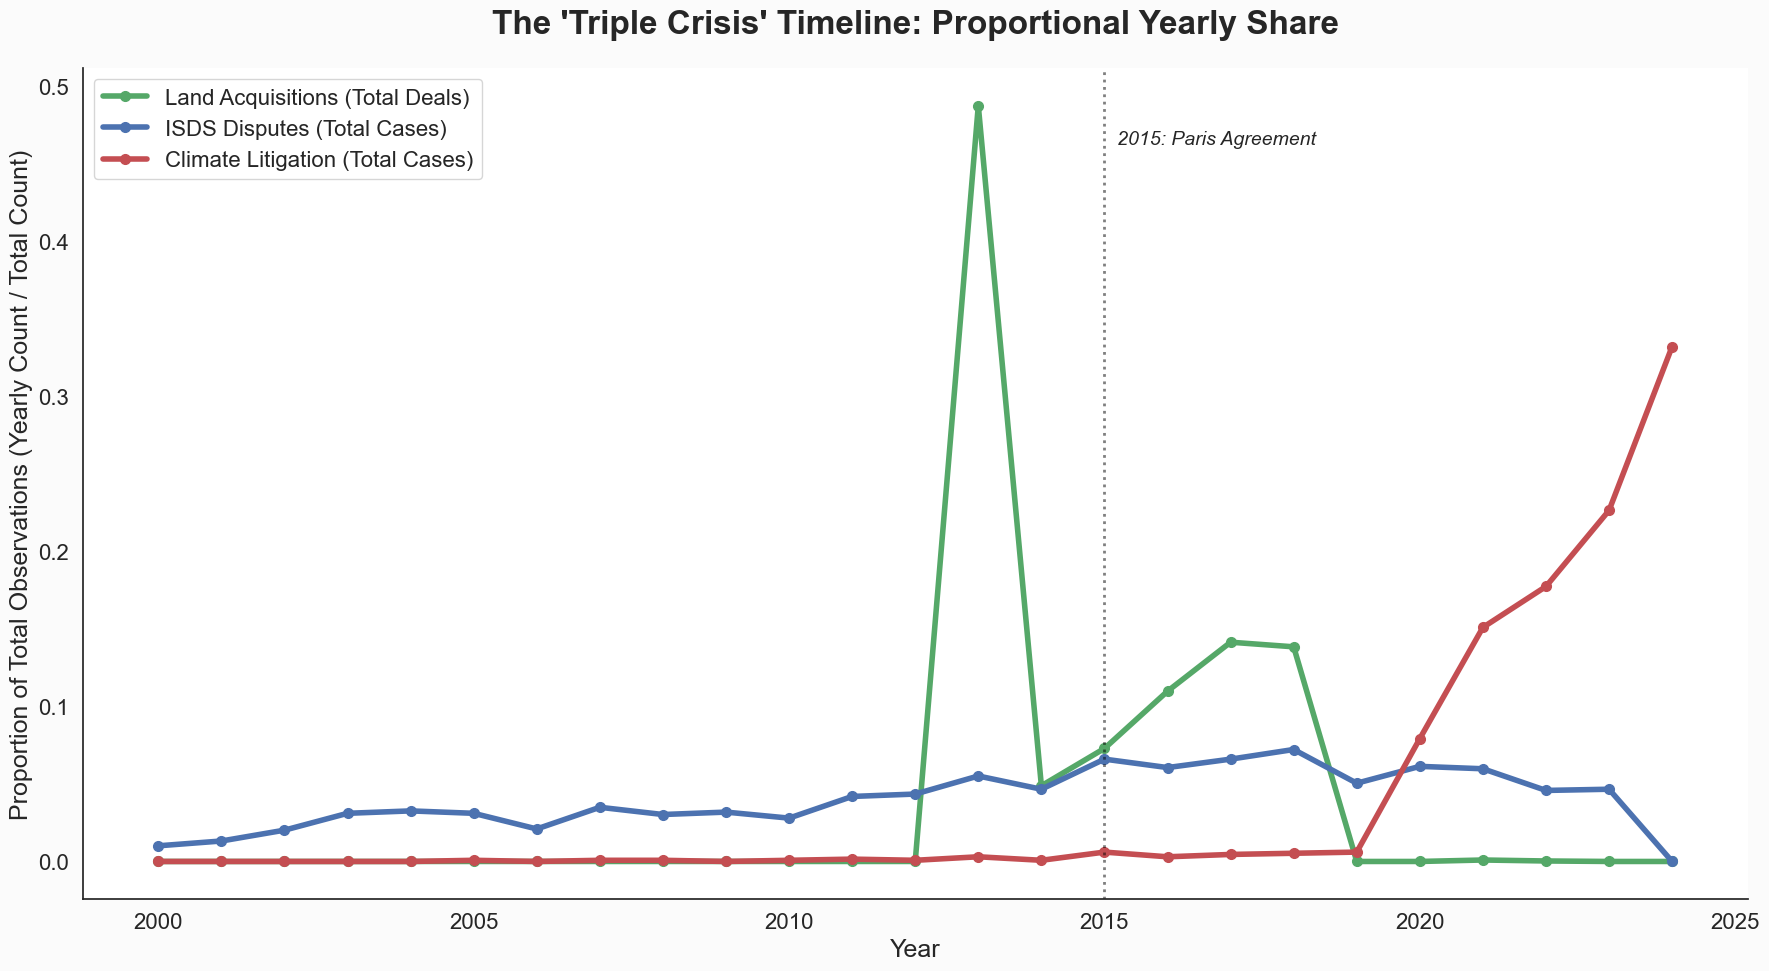

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------- Make everything bigger by default ----------
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 24,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16
})

# 1. Load the data directly from the files
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
land = pd.read_csv('landmatrix_final_analytical_dataset.csv')
climate = pd.read_csv('climate_litigation_final_unified.csv')

# 2. Extract years from each dataset
# ISDS uses 'year'
isds_years = pd.to_numeric(isds['year'], errors='coerce').dropna().astype(int)
isds_counts = isds_years.value_counts().sort_index()

# Land Matrix uses 'Created at' timestamp
land_years = pd.to_datetime(land['Created at'], errors='coerce').dt.year.dropna().astype(int)
land_counts = land_years.value_counts().sort_index()

# Climate Litigation uses 'Case Filing Year for Action'
climate_years = pd.to_numeric(climate['Case Filing Year for Action'], errors='coerce').dropna().astype(int)
climate_counts = climate_years.value_counts().sort_index()

# 3. Create a unified dataframe for the years 2000 to 2024
years_range = np.arange(2000, 2025)
data = pd.DataFrame({'Year': years_range})

# Merge the counts into the main dataframe
data = data.merge(land_counts.rename('Land'), left_on='Year', right_index=True, how='left').fillna(0)
data = data.merge(isds_counts.rename('ISDS'), left_on='Year', right_index=True, how='left').fillna(0)
data = data.merge(climate_counts.rename('Climate'), left_on='Year', right_index=True, how='left').fillna(0)

# 4. Normalize by the TOTAL sum (Proportional Share)
# This fulfills the "total amount of cases = 1" requirement
for col in ['Land', 'ISDS', 'Climate']:
    data[f'{col}_norm'] = data[col] / data[col].sum()

# 5. Create the Visualization (Lecture 03 Principles)
plt.figure(figsize=(18, 10), facecolor='#fbfbfb')  # bigger figure
sns.set_style("white")

# Plotting the normalized lines (bigger linewidth + markers)
plt.plot(
    data['Year'], data['Land_norm'],
    label='Land Acquisitions (Total Deals)',
    color='#55A868', linewidth=4, marker='o', markersize=7
)
plt.plot(
    data['Year'], data['ISDS_norm'],
    label='ISDS Disputes (Total Cases)',
    color='#4C72B0', linewidth=4, marker='o', markersize=7
)
plt.plot(
    data['Year'], data['Climate_norm'],
    label='Climate Litigation (Total Cases)',
    color='#C44E52', linewidth=4, marker='o', markersize=7
)

# Highlighting the Paris Agreement (Contextual detail) with larger annotation
max_val = data[['Land_norm', 'ISDS_norm', 'Climate_norm']].max().max()
plt.axvline(x=2015, color='black', linestyle=':', alpha=0.5, linewidth=2)
plt.text(2015.2, max_val * 0.95, "2015: Paris Agreement", fontsize=14, fontstyle='italic')

plt.title("The 'Triple Crisis' Timeline: Proportional Yearly Share", fontweight='bold', pad=25)
plt.xlabel("Year")
plt.ylabel("Proportion of Total Observations (Yearly Count / Total Count)")

plt.legend(frameon=True, loc='upper left')
sns.despine()  # Remove redundant ink

plt.tight_layout()
plt.savefig('activity_trends_proportional_revised.pdf')   # vector output, best quality
# If you need a Google Docs image too:
plt.savefig('activity_trends_proportional_revised.png', dpi=600)

plt.show()


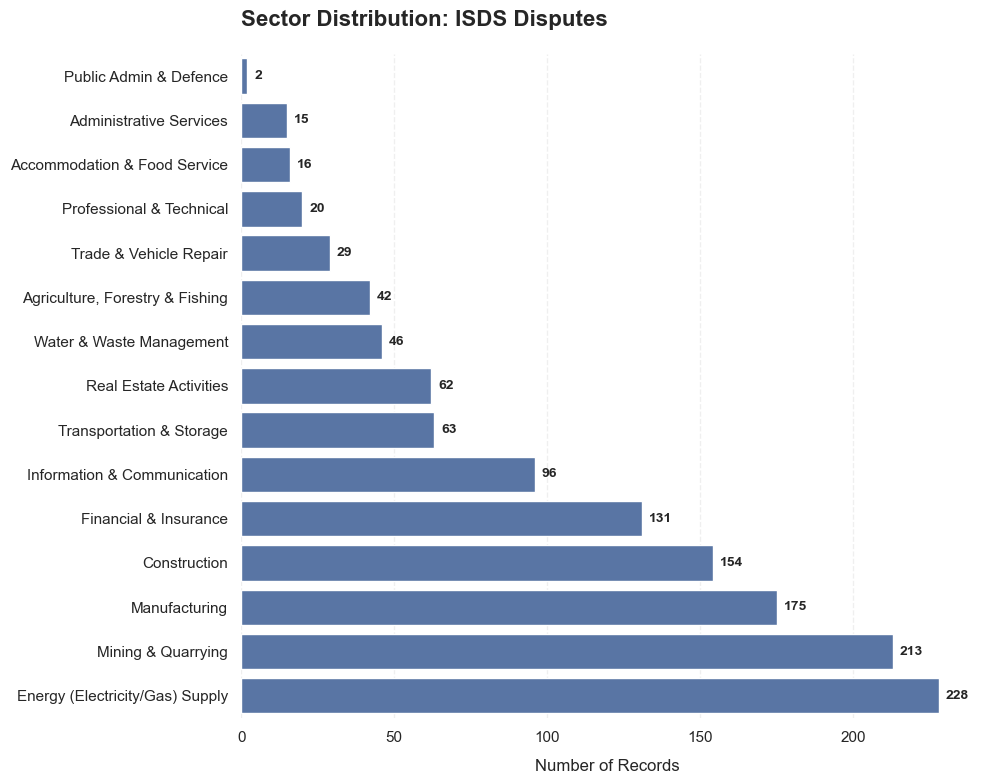

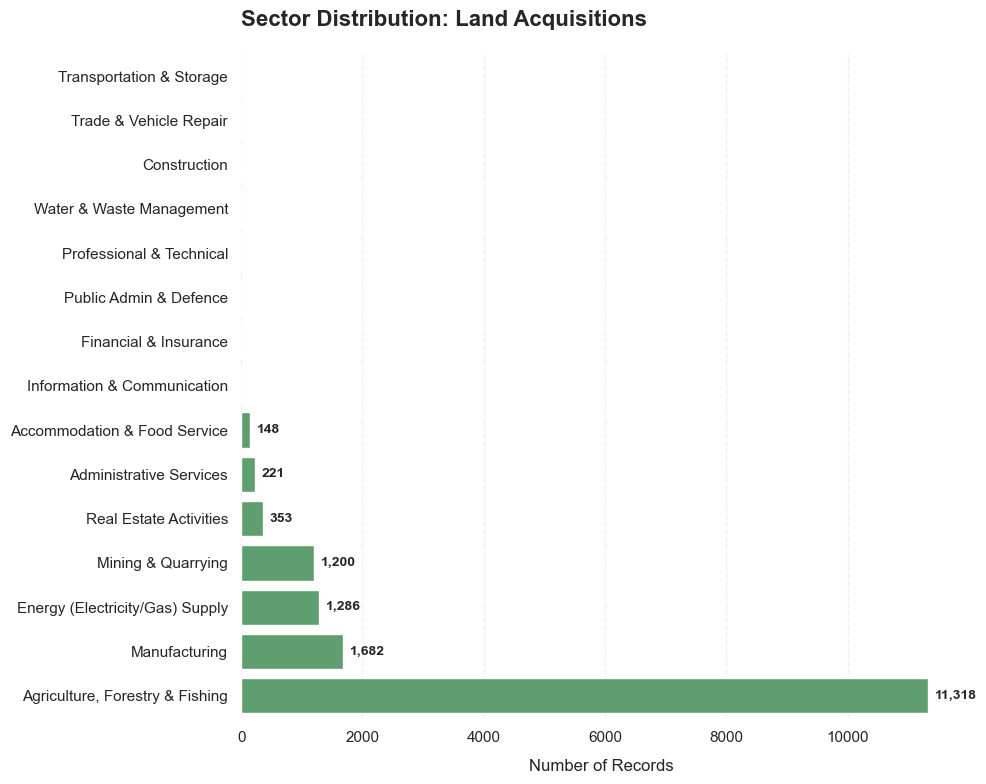

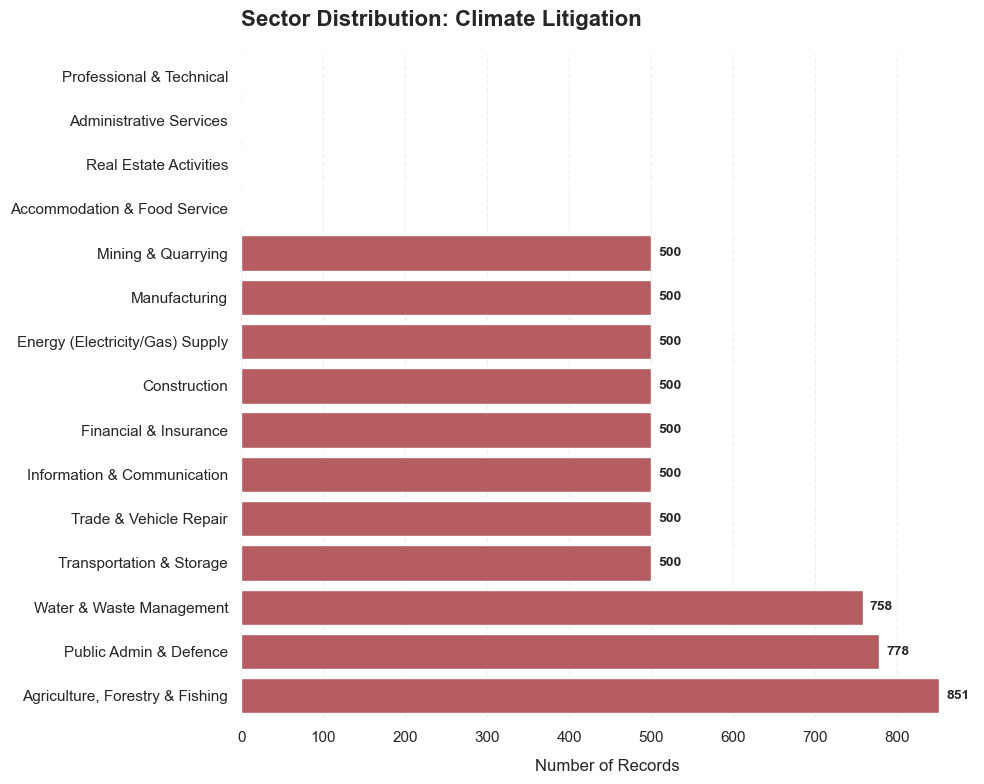

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the Sector Taxonomy Mapping
sector_map = {
    'sector_A': 'Agriculture, Forestry & Fishing',
    'sector_B': 'Mining & Quarrying',
    'sector_C': 'Manufacturing',
    'sector_D': 'Energy (Electricity/Gas) Supply',
    'sector_E': 'Water & Waste Management',
    'sector_F': 'Construction',
    'sector_G': 'Trade & Vehicle Repair',
    'sector_H': 'Transportation & Storage',
    'sector_I': 'Accommodation & Food Service',
    'sector_J': 'Information & Communication',
    'sector_K': 'Financial & Insurance',
    'sector_L': 'Real Estate Activities',
    'sector_M': 'Professional & Technical',
    'sector_N': 'Administrative Services',
    'sector_O': 'Public Admin & Defence'
}

# 2. Function to process datasets and aggregate sector counts
def get_sector_counts(file_path):
    df = pd.read_csv(file_path)
    # Filter for the sector columns present in the file
    cols = [c for c in sector_map.keys() if c in df.columns]
    sums = df[cols].sum().reset_index()
    sums.columns = ['sector_id', 'count']
    sums['sector_name'] = sums['sector_id'].map(sector_map)
    # Sort ascending for horizontal plot (highest values at the top)
    return sums.sort_values(by='count', ascending=True)

# 3. Load the data
isds_data = get_sector_counts('ISDS_processed_dataset_final.csv')
land_data = get_sector_counts('landmatrix_final_analytical_dataset.csv')
climate_data = get_sector_counts('climate_litigation_final_unified.csv')

# 4. Standardized Plotting Function (Applying Lecture 03 & 04 Principles)
def create_sector_plot(df, title, color, filename):
    plt.figure(figsize=(10, 8))
    sns.set_style("white") # Clean, no-junk style
    
    # Horizontal Bar Chart
    ax = sns.barplot(data=df, x='count', y='sector_name', color=color)
    
    # Add direct labels (Principle: Serve a clear purpose / Reveal detail)
    for p in ax.patches:
        width = p.get_width()
        if width > 0:
            ax.annotate(f'{int(width):,}', 
                        (width, p.get_y() + p.get_height() / 2),
                        ha='left', va='center', 
                        xytext=(5, 0), 
                        textcoords='offset points',
                        fontsize=10, fontweight='bold')
    
    # Minimalist styling
    plt.title(title, fontsize=16, fontweight='bold', loc='left', pad=20)
    plt.xlabel('Number of Records', fontsize=12, labelpad=10)
    plt.ylabel('') # Labels on Y-axis are self-explanatory
    
    # Remove unnecessary ink (Tufte Principle)
    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# 5. Generate and save the three separate plots
create_sector_plot(isds_data, "Sector Distribution: ISDS Disputes", "#4C72B0", "plot_isds_sectors.pdf")
create_sector_plot(land_data, "Sector Distribution: Land Acquisitions", "#55A868", "plot_land_sectors.pdf")
create_sector_plot(climate_data, "Sector Distribution: Climate Litigation", "#C44E52", "plot_climate_sectors.pdf")

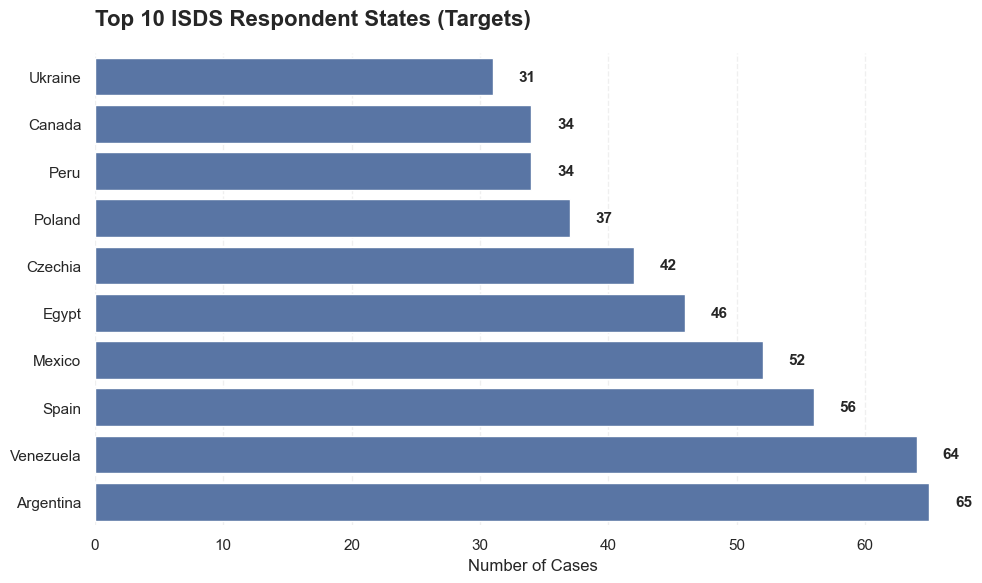

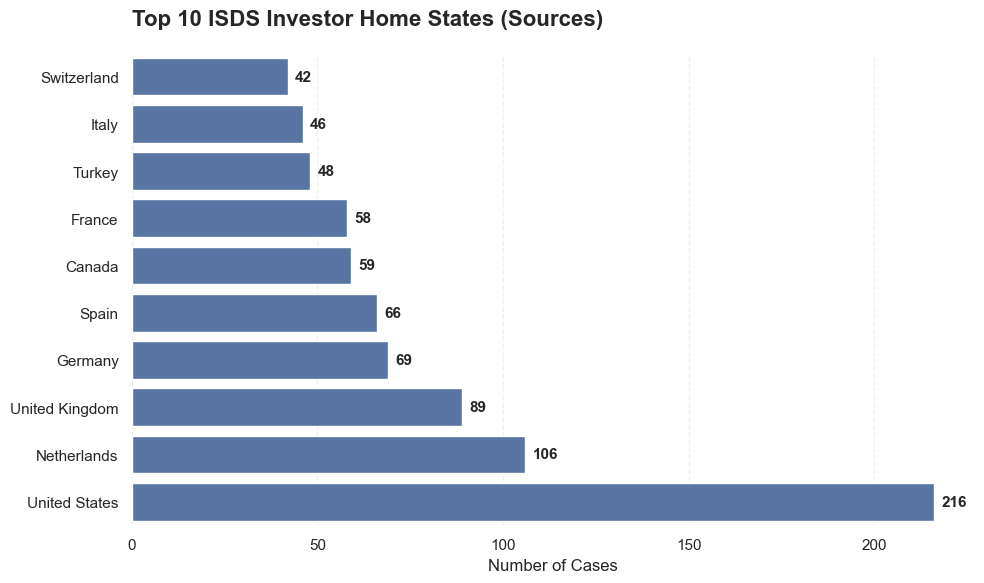

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the primary datasets
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# 2. Standardize ISO3 Country Codes
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# 3. Calculate Top 10 Respondent and Investor Counts
resp_counts = isds['resp_iso3'].value_counts().head(10).reset_index()
resp_counts.columns = ['iso3', 'count']

inv_counts = isds['inv_iso3'].value_counts().head(10).reset_index()
inv_counts.columns = ['iso3', 'count']

# 4. Map ISO codes to full country names
name_map = dict(zip(indep['iso3'], indep['Country']))
resp_counts['Country'] = resp_counts['iso3'].map(name_map).fillna(resp_counts['iso3'])
inv_counts['Country'] = inv_counts['iso3'].map(name_map).fillna(inv_counts['iso3'])

# 5. Styling Function (Lec 03 principles)
def style_isds_plot(df, title, filename, color='#4C72B0'):
    plt.figure(figsize=(10, 6))
    sns.set_style("white") 
    df_sorted = df.sort_values(by='count', ascending=True)
    ax = sns.barplot(x='count', y='Country', data=df_sorted, color=color)
    
    # Direct labels
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 2, p.get_y() + p.get_height()/2, f'{int(width)}', 
                 va='center', fontweight='bold', fontsize=11)
    
    plt.title(title, fontsize=16, fontweight='bold', loc='left', pad=20)
    plt.xlabel('Number of Cases', fontsize=12)
    plt.ylabel('')
    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)

# 6. Generate Plots
style_isds_plot(resp_counts, "Top 10 ISDS Respondent States (Targets)", "isds_top_respondents.pdf")
style_isds_plot(inv_counts, "Top 10 ISDS Investor Home States (Sources)", "isds_top_investors.pdf")

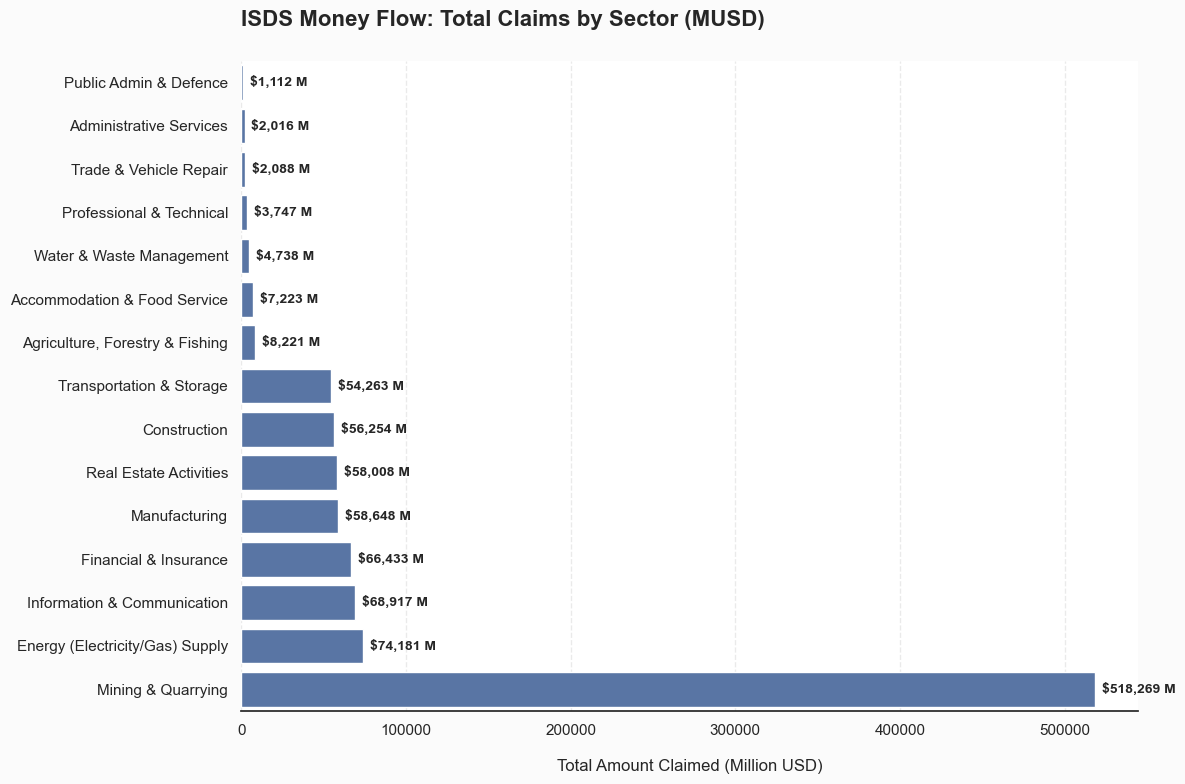

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the primary dataset
isds = pd.read_csv('ISDS_processed_dataset_final.csv')

# 2. Sector Mapping (NACE Taxonomy)
sector_map = {
    'sector_A': 'Agriculture, Forestry & Fishing',
    'sector_B': 'Mining & Quarrying',
    'sector_C': 'Manufacturing',
    'sector_D': 'Energy (Electricity/Gas) Supply',
    'sector_E': 'Water & Waste Management',
    'sector_F': 'Construction',
    'sector_G': 'Trade & Vehicle Repair',
    'sector_H': 'Transportation & Storage',
    'sector_I': 'Accommodation & Food Service',
    'sector_J': 'Information & Communication',
    'sector_K': 'Financial & Insurance',
    'sector_L': 'Real Estate Activities',
    'sector_M': 'Professional & Technical',
    'sector_N': 'Administrative Services',
    'sector_O': 'Public Admin & Defence'
}

# 3. Calculate claims by sector directly from the file
sector_money = []
for col, name in sector_map.items():
    if col in isds.columns:
        # Sum the amount claimed for cases marked with '1' in the sector column
        total = isds[isds[col] == 1]['amount_claimed_musd'].sum()
        sector_money.append({'Sector': name, 'Amount_MUSD': total})

# Create DataFrame and sort for visualization
df_money = pd.DataFrame(sector_money).sort_values(by='Amount_MUSD', ascending=True)

# 4. Design following Lecture 03 Principles (No Chart Junk, Clear Purpose)
plt.figure(figsize=(12, 8), facecolor='#fbfbfb')
sns.set_theme(style="white")
isds_blue = '#4C72B0' # Consistent ISDS Blue colorscheme

# Create Plot
ax = sns.barplot(x='Amount_MUSD', y='Sector', data=df_money, color=isds_blue)

# 5. Add Direct Labels (Lecture 03 Tip: Reveal detail from overview to structure)
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'${width:,.0f} M', 
                    (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', 
                    xytext=(5, 0), 
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

# 6. Final Polish (Omit Chart Junk)
plt.title('ISDS Money Flow: Total Claims by Sector (MUSD)', fontsize=16, fontweight='bold', loc='left', pad=25)
plt.xlabel('Total Amount Claimed (Million USD)', fontsize=12, labelpad=15)
plt.ylabel('')
sns.despine(left=True, bottom=False)
plt.grid(axis='x', linestyle='--', alpha=0.4) # Subtle guide lines for readability

plt.tight_layout()
plt.savefig('isds_money_flow_by_sector.pdf')
plt.show()

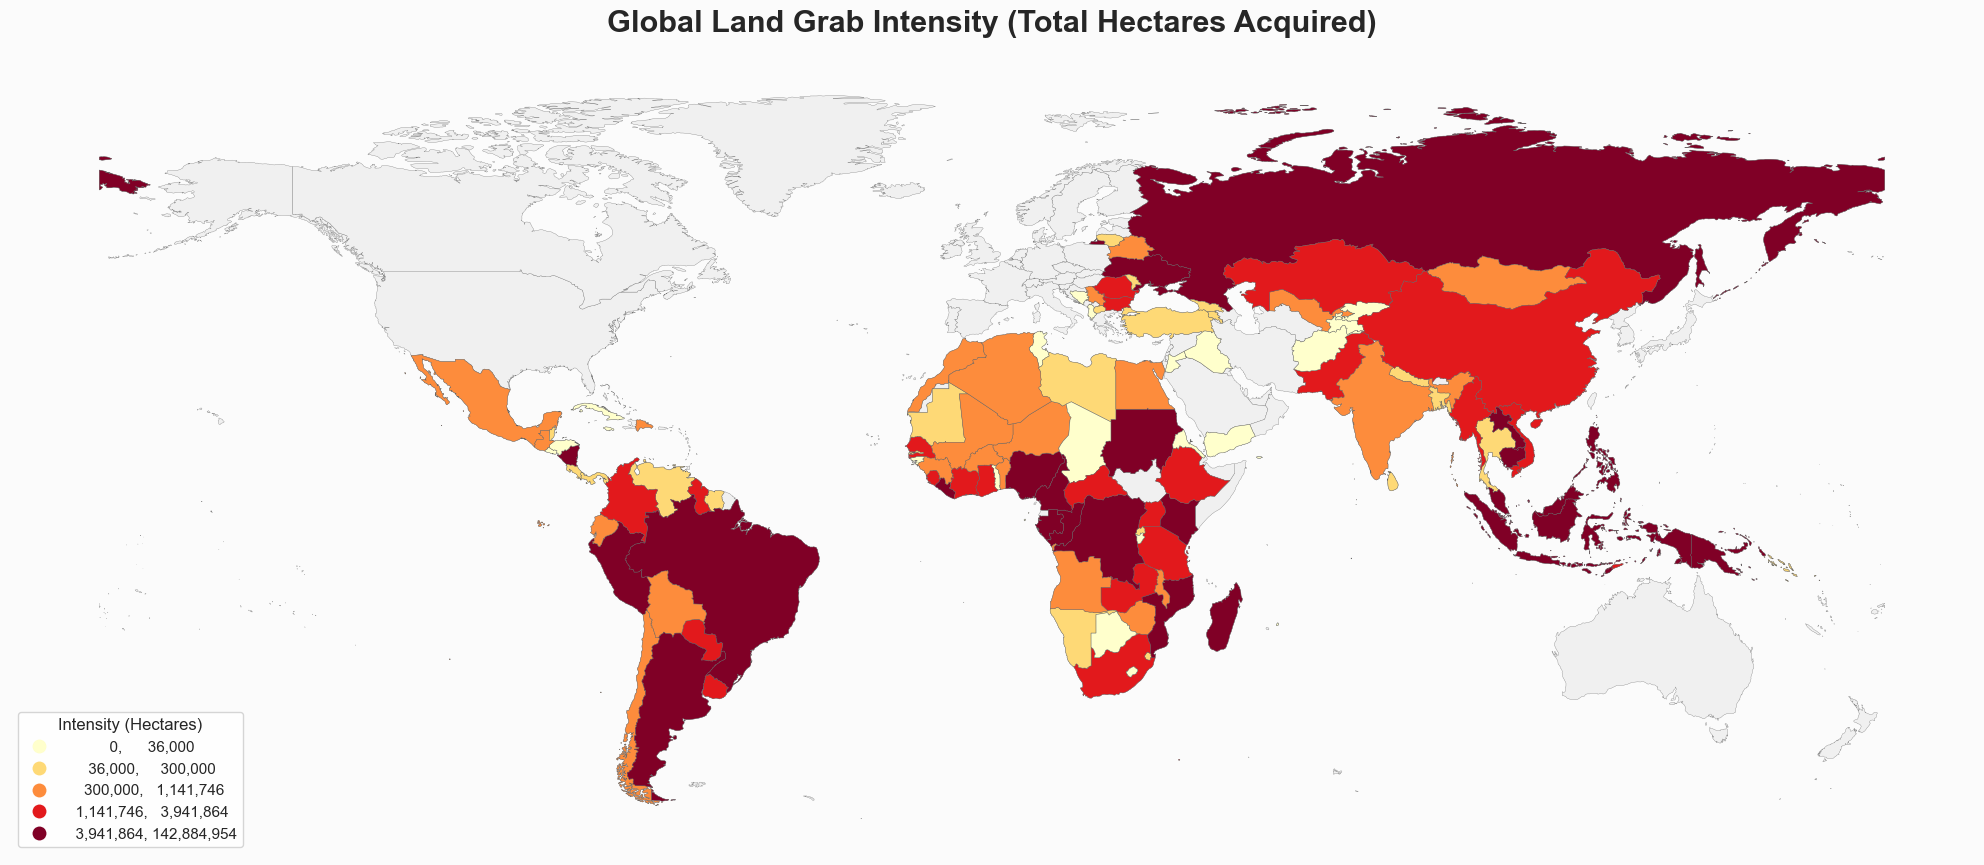

In [39]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the World Map (Specific User Method)
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world = world.rename(columns={"ADMIN": "country", "ADM0_A3": "iso3"})[["country", "iso3", "geometry"]]
world = world[world["country"] != "Antarctica"]

# 2. Prepare Land Matrix Data
land = pd.read_csv('landmatrix_final_analytical_dataset.csv')
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()

# Aggregate intensity (Total hectares) for every country
global_land = land.groupby('iso3')['Deal size'].sum().reset_index()
global_land.columns = ['iso3', 'total_hectares']

# 3. Merge with World Geometry
map_df = world.merge(global_land, on='iso3', how='left')

# 4. Create the Map (Lecture 04 Principles)
fig, ax = plt.subplots(figsize=(20, 10), facecolor='#fbfbfb')

# Background Layer (Lecture 03: Show missing data/context)
world.plot(ax=ax, color='#f0f0f0', edgecolor='#636363', linewidth=0.2)

# Choropleth Layer: Using Quantiles (Slide 54)
# YlOrRd is the standard sequential colormap for 'Intensity'
map_df.dropna(subset=['total_hectares']).plot(
    column='total_hectares',
    ax=ax,
    cmap='YlOrRd',
    scheme='quantiles', # Correct binning for skewed spatial data
    k=5,               # 5 Distinct Bins
    legend=True,
    legend_kwds={
        'loc': 'lower left',
        'title': 'Intensity (Hectares)',
        'fmt': "{:,.0f}",
        'frameon': True
    },
    edgecolor='#636363',
    linewidth=0.3
)

# Principles from Lecture 03: Minimalist Design
plt.title("Global Land Grab Intensity (Total Hectares Acquired)", fontsize=22, fontweight='bold', pad=20)
plt.axis('off')

# Zoom into the legend to make it readable
plt.tight_layout()
plt.show()

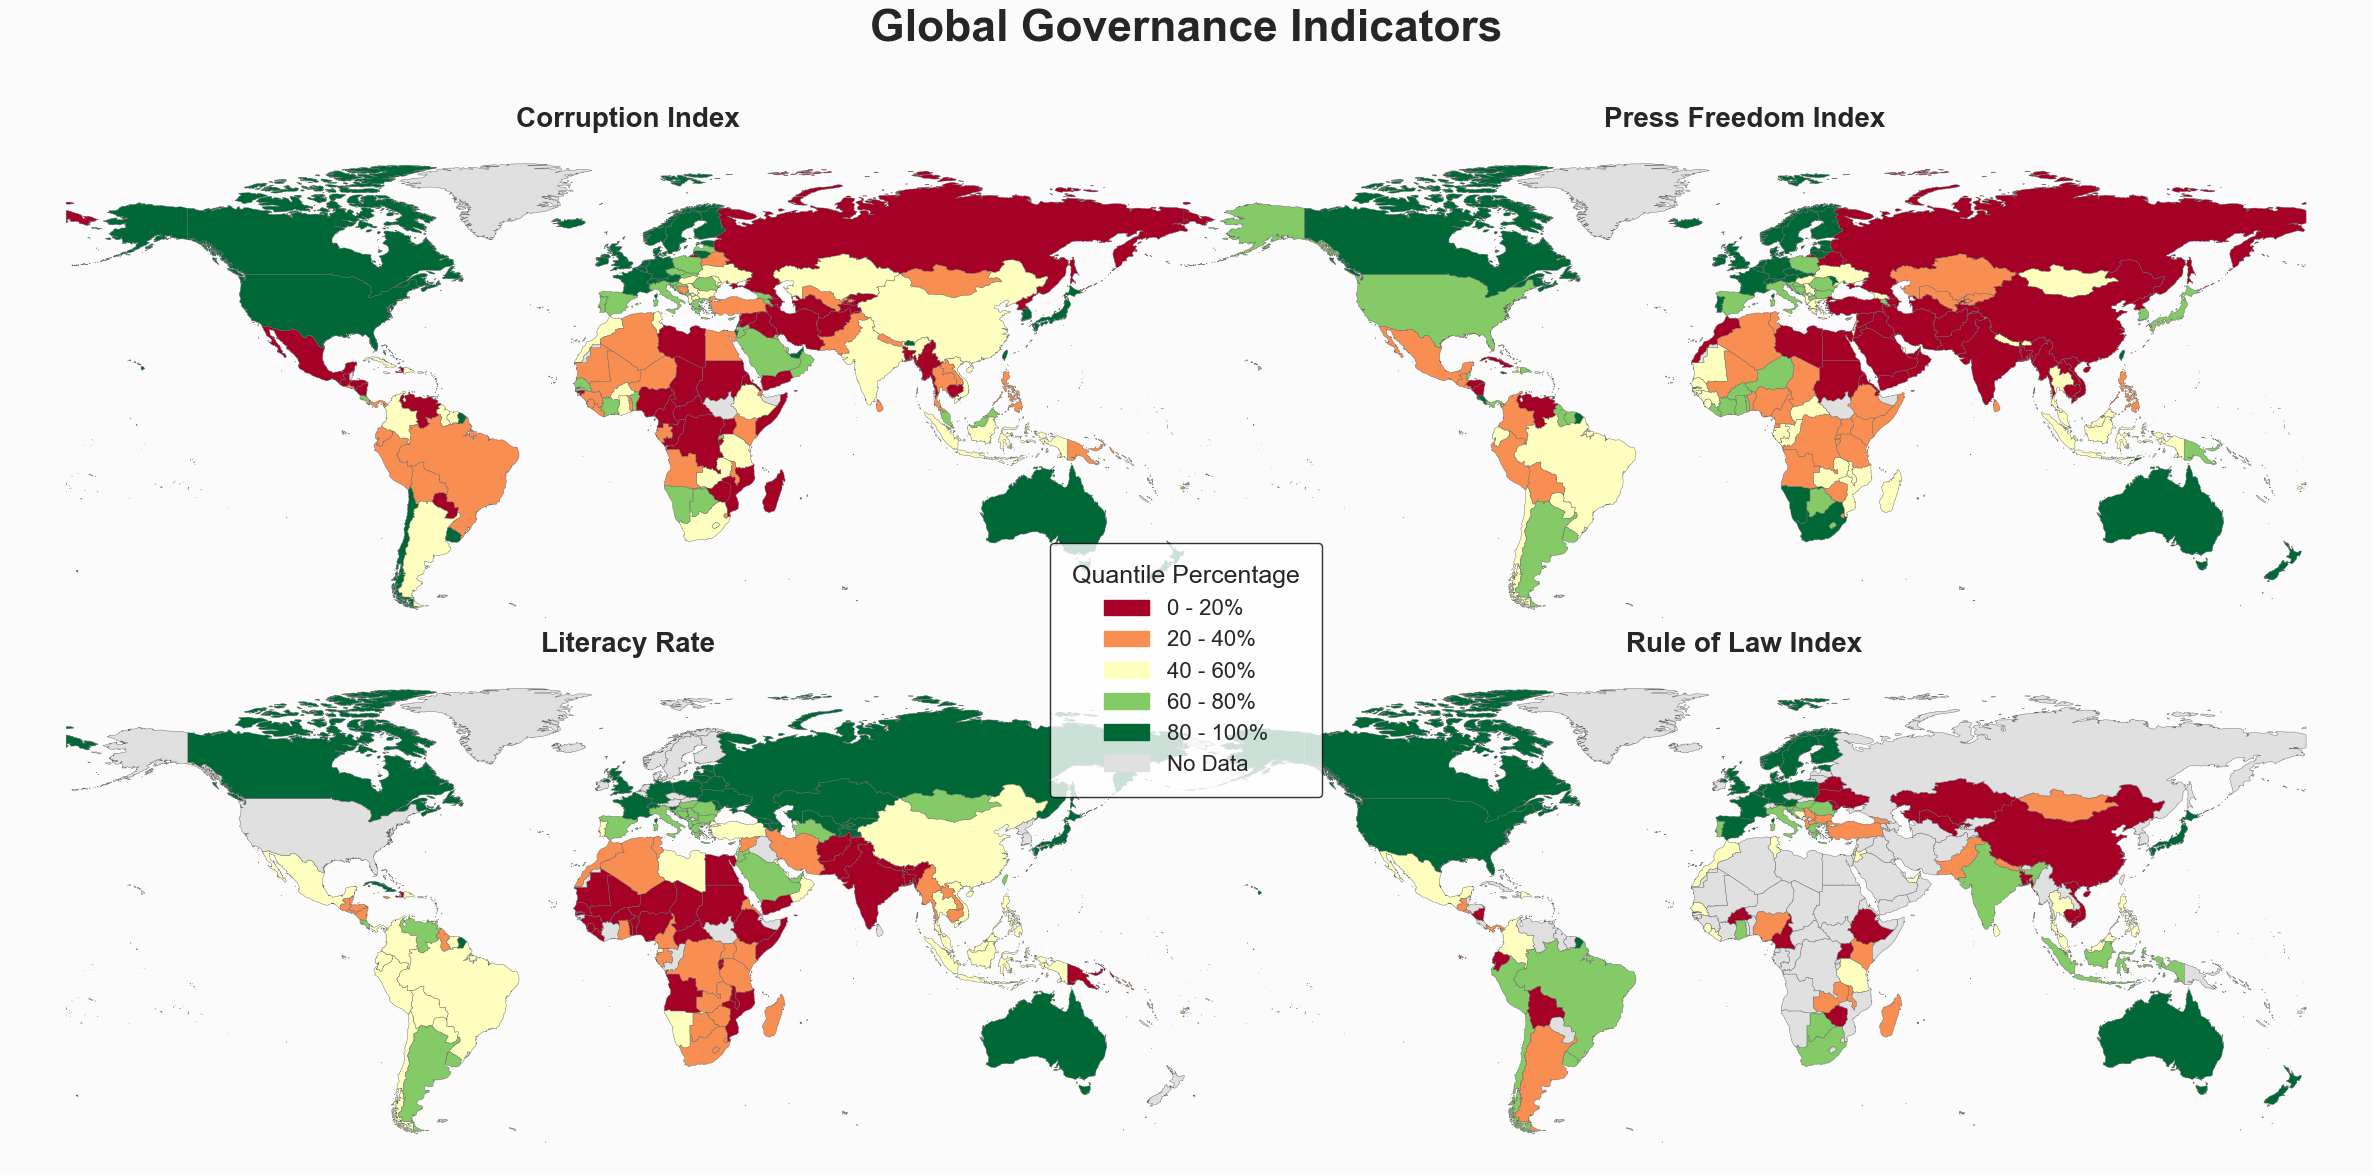

In [84]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# ---------- Style & Principles (Lec 03) ----------
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 20,
    "axes.labelsize": 16
})

# 1. Load the World Map
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world = world.rename(columns={"ADMIN": "country", "ADM0_A3": "iso3"})[["country", "iso3", "geometry"]]
world = world[world["country"] != "Antarctica"]

# 2. Prepare Governance Data
indep = pd.read_csv('combined_independent_variables.csv')
indep['iso3'] = indep['ISO3'].str.strip().str.upper()
map_df = world.merge(indep, on='iso3', how='left')

# 3. Setup 2x2 Plot
# REMOVED (%) from 'Literacy Rate' below
indicators = [
    ('Corruption_Score', 'Corruption Index'),
    ('Press_Freedom_Score', 'Press Freedom Index'),
    ('Literacy_Rate_Pct', 'Literacy Rate'),
    ('Rule_of_Law_Score_Pct', 'Rule of Law Index')
]

fig, axes = plt.subplots(2, 2, figsize=(24, 12), facecolor='#fbfbfb')
axes = axes.flatten()

cmap = plt.get_cmap('RdYlGn')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
pct_labels = ["0 - 20%", "20 - 40%", "40 - 60%", "60 - 80%", "80 - 100%"]

for i, (col, title) in enumerate(indicators):
    ax = axes[i]
    map_df.plot(
        column=col,
        ax=ax,
        cmap='RdYlGn',
        scheme='quantiles',
        k=5,
        legend=False, 
        missing_kwds={"color": "#e0e0e0"},
        edgecolor='#636363',
        linewidth=0.3
    )
    ax.set_title(title, fontweight='bold', pad=10)
    ax.axis('off')

# ---------- 4. CREATE THE DEAD CENTER LEGEND ----------
legend_patches = [mpatches.Patch(color=colors[i], label=pct_labels[i]) for i in range(5)]
legend_patches.append(mpatches.Patch(color='#e0e0e0', label='No Data'))

fig.legend(
    handles=legend_patches,
    bbox_to_anchor=(0.5, 0.43), # Positioned slightly down from center
    loc='center',
    ncol=1,
    fontsize=16,
    title="Quantile Percentage",
    title_fontsize=18,
    frameon=True,
    facecolor='white',
    edgecolor='black',
    borderpad=1
)

# ---------- 5. FINAL POLISH & SPACING FIX ----------
plt.suptitle(
    "Global Governance Indicators",
    fontsize=32, fontweight='bold', y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.subplots_adjust(wspace=-0.1, hspace=0.05) 

plt.savefig('Governance_Indicators_Central_Legend.png', dpi=600, bbox_inches='tight')
plt.show()

C:\Users\jobm3\AppData\Local\Temp\ipykernel_27776\832079912.py:84: UserWarning:

Glyph 10132 (\N{HEAVY WIDE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.

C:\Users\jobm3\AppData\Local\Temp\ipykernel_27776\832079912.py:85: UserWarning:

Glyph 10132 (\N{HEAVY WIDE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.

C:\Users\jobm3\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 10132 (\N{HEAVY WIDE-HEADED RIGHTWARDS ARROW}) missing from font(s) Arial.



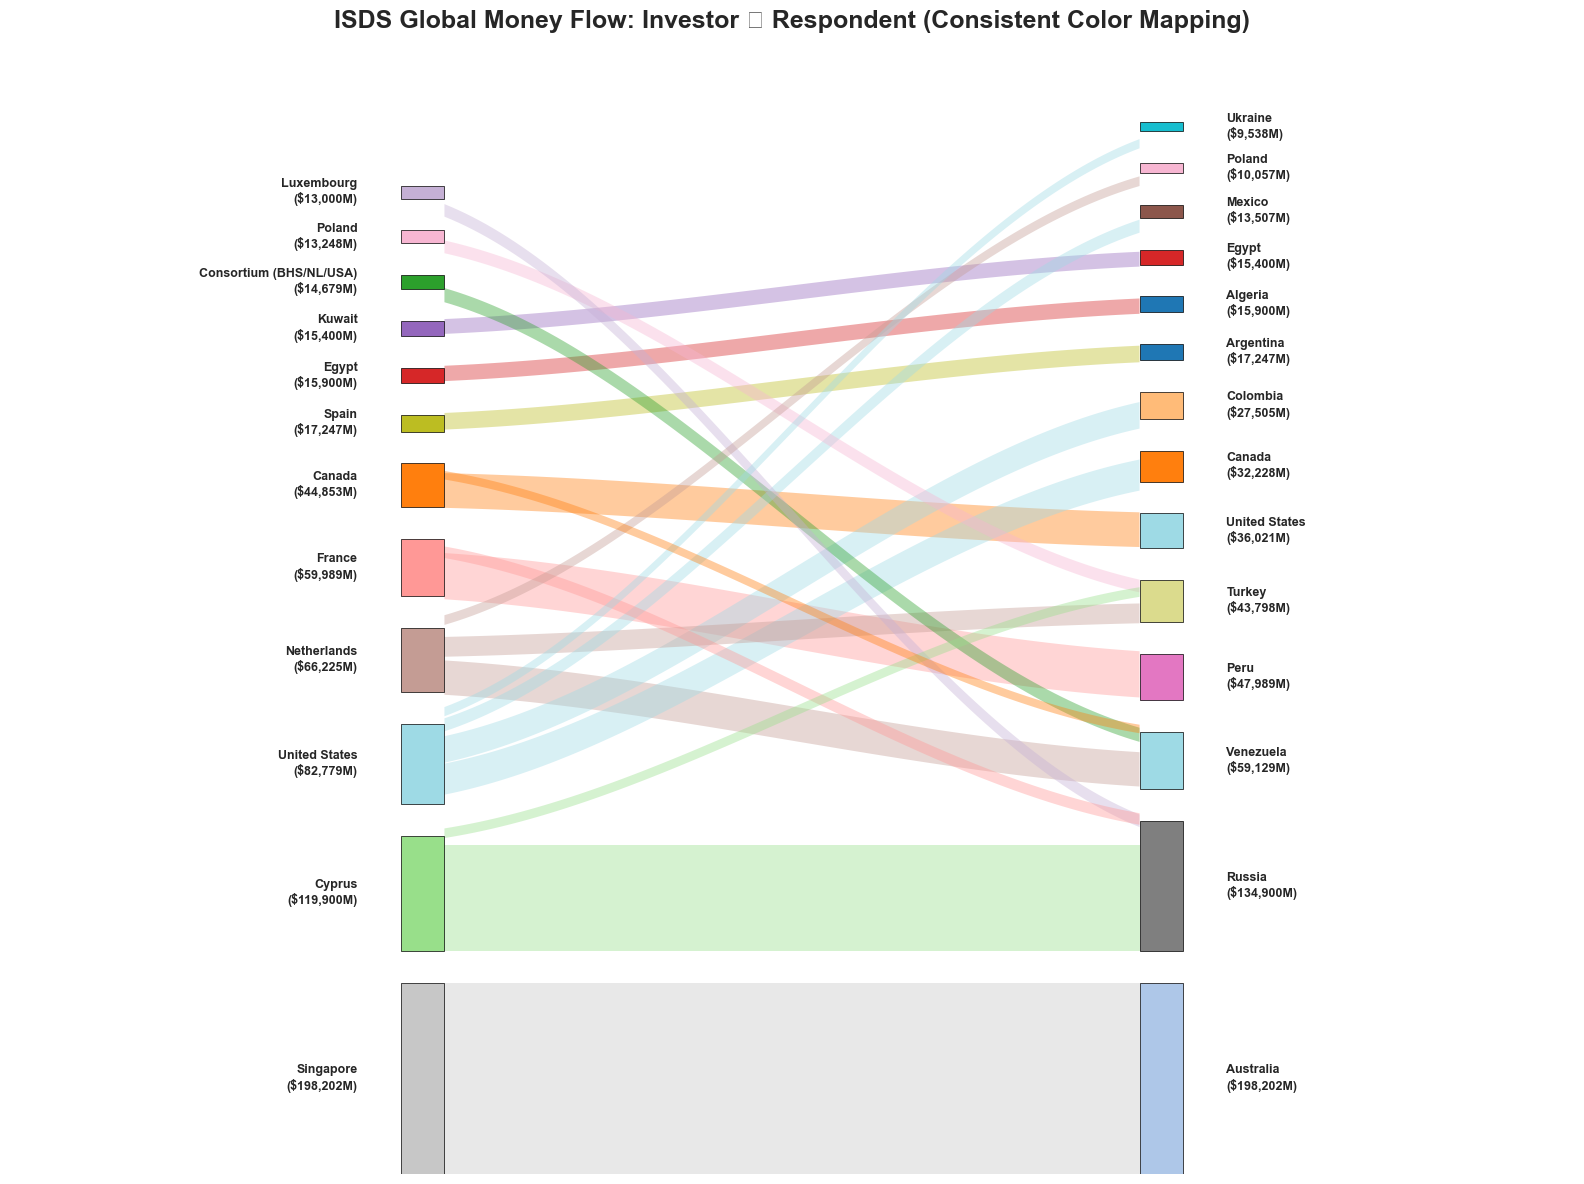

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data for Top 20 Flows
name_map = {
    'SGP': 'Singapore', 'AUS': 'Australia', 'CYP': 'Cyprus', 'RUS': 'Russia',
    'FRA': 'France', 'PER': 'Peru', 'CAN': 'Canada', 'USA': 'United States',
    'NLD': 'Netherlands', 'VEN': 'Venezuela', 'COL': 'Colombia', 'TUR': 'Turkey',
    'ESP': 'Spain', 'ARG': 'Argentina', 'EGY': 'Egypt', 'DZA': 'Algeria',
    'KWT': 'Kuwait', 'POL': 'Poland', 'LUX': 'Luxembourg', 'MEX': 'Mexico',
    'UKR': 'Ukraine', 'BHS; NLD; USA': 'Consortium (BHS/NL/USA)'
}

data = [
    ('SGP', 'AUS', 198202.40), ('CYP', 'RUS', 109900.00), ('FRA', 'PER', 47989.00),
    ('CAN', 'USA', 36021.40), ('NLD', 'VEN', 35618.20), ('USA', 'CAN', 32228.50),
    ('USA', 'COL', 27505.40), ('NLD', 'TUR', 20550.00), ('ESP', 'ARG', 17246.60),
    ('EGY', 'DZA', 15900.00), ('KWT', 'EGY', 15400.00), ('BHS; NLD; USA', 'VEN', 14679.00),
    ('USA', 'MEX', 13507.10), ('POL', 'TUR', 13248.00), ('LUX', 'RUS', 13000.00),
    ('FRA', 'RUS', 12000.00), ('NLD', 'POL', 10056.60), ('CYP', 'TUR', 10000.00),
    ('USA', 'UKR', 9537.60), ('CAN', 'VEN', 8832.00)
]

df = pd.DataFrame(data, columns=['investor', 'respondent', 'amount'])
df['source'] = df['investor'].map(name_map).fillna(df['investor'])
df['target'] = df['respondent'].map(name_map).fillna(df['respondent'])

# 2. Assign Global Colors per Unique Country
unique_countries = sorted(list(set(df['source']) | set(df['target'])))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_countries)))
country_color_map = {name: colors[i] for i, name in enumerate(unique_countries)}

# 3. Custom Sankey Logic
def draw_consistent_sankey(df, color_map):
    plt.figure(figsize=(16, 12))
    ax = plt.gca()
    
    sources = df.groupby('source')['amount'].sum().sort_values(ascending=False)
    targets = df.groupby('target')['amount'].sum().sort_values(ascending=False)
    total_amount = df['amount'].sum()
    gap = 0.05 * total_amount
    
    # Calculate Y positions for stacking
    y_source, current_y = {}, 0
    for name, amt in sources.items():
        y_source[name] = (current_y, current_y + amt)
        current_y += amt + gap
    
    y_target, current_y = {}, 0
    for name, amt in targets.items():
        y_target[name] = (current_y, current_y + amt)
        current_y += amt + gap
    
    target_offsets = {name: y_target[name][0] for name in targets.index}
    source_offsets = {name: y_source[name][0] for name in sources.index}

    # Draw Ribbons
    for _, row in df.iterrows():
        s, t, amt = row['source'], row['target'], row['amount']
        y0_start, y1_start = source_offsets[s], target_offsets[t]
        
        x = np.linspace(0.1, 0.9, 100)
        y_curve = (y1_start + amt/2 - (y0_start + amt/2)) * (3*x**2 - 2*x**3) + (y0_start + amt/2)
        
        plt.fill_between(x, y_curve - amt/2, y_curve + amt/2, 
                         color=color_map[s], alpha=0.4, edgecolor='none')
        
        source_offsets[s] += amt
        target_offsets[t] += amt

    # Draw Node Bars (Investor Side)
    for name, (y0, y1) in y_source.items():
        plt.bar(0.05, y1-y0, bottom=y0, width=0.05, color=color_map[name], align='edge', edgecolor='black', linewidth=0.5)
        plt.text(0, (y0+y1)/2, f"{name}\n(${y1-y0:,.0f}M)", ha='right', va='center', fontweight='bold', fontsize=9)

    # Draw Node Bars (Respondent Side - same colors as investors)
    for name, (y0, y1) in y_target.items():
        plt.bar(0.9, y1-y0, bottom=y0, width=0.05, color=color_map[name], align='edge', edgecolor='black', linewidth=0.5)
        plt.text(1, (y0+y1)/2, f"{name}\n(${y1-y0:,.0f}M)", ha='left', va='center', fontweight='bold', fontsize=9)

    plt.title("ISDS Global Money Flow: Investor ➔ Respondent (Consistent Color Mapping)", fontsize=18, fontweight='bold', pad=30)
    plt.xlim(-0.4, 1.4); plt.axis('off')
    plt.tight_layout()
    plt.savefig('sankey_consistent_colors.png', dpi=300)
    plt.show()

draw_consistent_sankey(df, country_color_map)

--- SUMMARY STATISTICS ---
       Corruption_Score  Press_Freedom_Score  Literacy_Rate_Pct  \
count        181.000000           181.000000         157.000000   
mean          42.541436            58.362873          86.101911   
std           19.309315            16.934856          17.867455   
min            8.000000            21.720000          27.000000   
25%           27.000000            45.850000          80.000000   
50%           40.000000            59.160000          95.000000   
75%           56.000000            71.060000          99.000000   
max           90.000000            95.180000         100.000000   

       Rule_of_Law_Score_Pct  
count              89.000000  
mean               57.560726  
std                16.929911  
min                23.712807  
25%                45.757113  
50%                55.258648  
75%                71.324941  
max                92.751618  

--- MISSING DATA ---
Corruption_Score          10
Press_Freedom_Score       10
Literacy_R

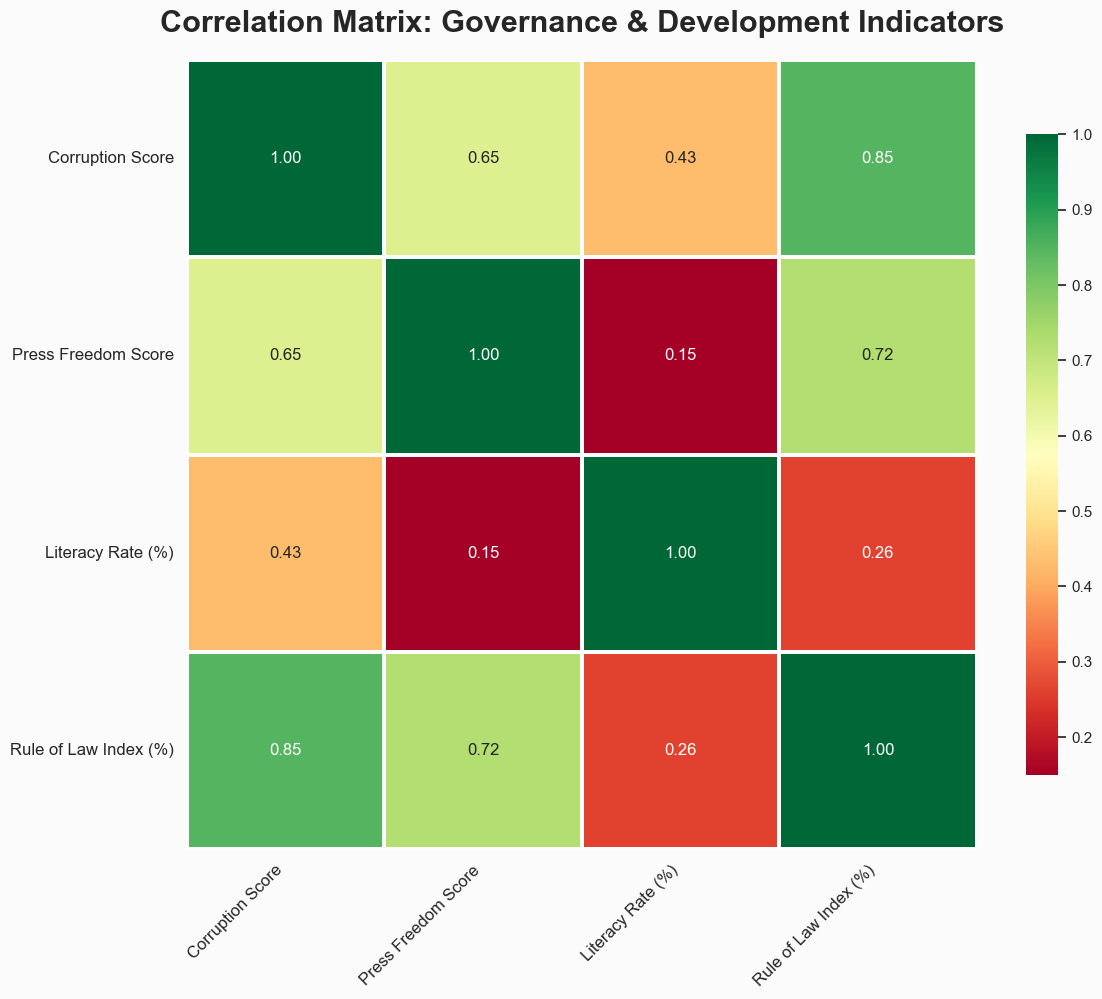

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load data
# Note: Ensure this file is in your directory
indep = pd.read_csv('combined_independent_variables.csv')

# Define labels for the indicators to make them readable on the plot
friendly_labels = {
    'Corruption_Score': 'Corruption Score',
    'Press_Freedom_Score': 'Press Freedom Score',
    'Literacy_Rate_Pct': 'Literacy Rate (%)',
    'Rule_of_Law_Score_Pct': 'Rule of Law Index (%)'
}

indicators = list(friendly_labels.keys())

# 2. Summary Statistics
print("--- SUMMARY STATISTICS ---")
print(indep[indicators].describe())

# 3. Missing Data Analysis
print("\n--- MISSING DATA ---")
print(indep[indicators].isnull().sum())

# 4. Correlation Heatmap (Lec 03/08)
# Create a figure using subplots for better control
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#fbfbfb')

sns.set_theme(style="white")

# Calculate correlation and rename for the heatmap labels
corr = indep[indicators].corr()
corr.columns = [friendly_labels[col] for col in corr.columns]
corr.index = [friendly_labels[col] for col in corr.index]

# Draw the heatmap with clear formatting
sns.heatmap(
    corr, 
    annot=True, 
    cmap='RdYlGn', 
    fmt=".2f", 
    linewidths=1.5,
    cbar_kws={"shrink": .8},
    square=True,
    ax=ax
)

# --- CLEAR AXES LABELS (Request fulfilled) ---
plt.title('Correlation Matrix: Governance & Development Indicators', 
          fontsize=22, fontweight='bold', pad=20)

# Rotate X labels for better readability (Lecture 03)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.savefig('governance_correlation_heatmap_final.png', dpi=600)
# plt.show() # Commented out as per guidelines

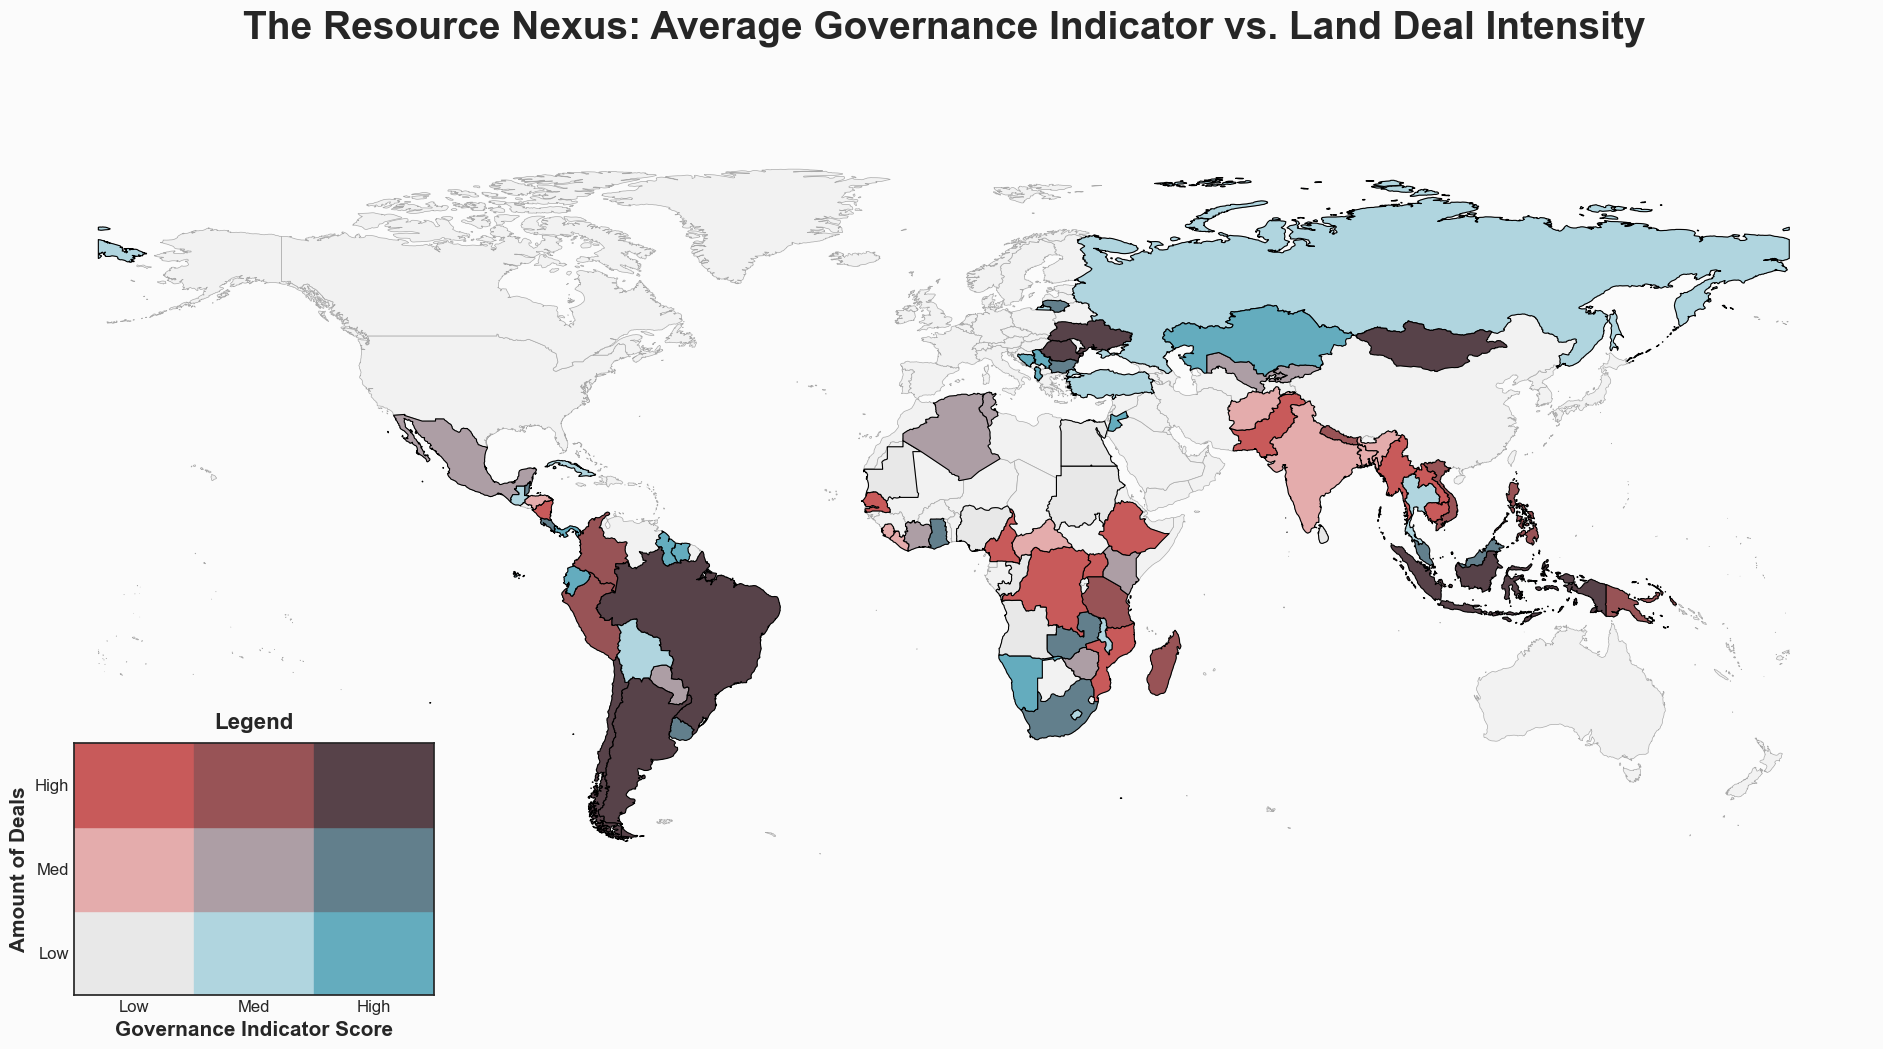

In [90]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# --- 1. SETTINGS & STYLE (Lec 03) ---
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 28,
    "axes.labelsize": 18
})

bivariate_colors = [
    "#e8e8e8", "#b0d5df", "#64acbe", # Low Y: Grey -> Blue
    "#e4acac", "#ad9ea5", "#627f8c", # Med Y
    "#c85a5a", "#985356", "#574249"  # High Y: Red -> Dark (High Vulnerability)
]

def get_bivariate_color(val_x, val_y):
    if pd.isna(val_x) or pd.isna(val_y): return None
    return bivariate_colors[int(val_x + val_y * 3)]

def create_bins(df, column):
    # Lec 04: Quantile classification using ranks
    return pd.qcut(df[column].rank(method='first'), 3, labels=[0, 1, 2]).astype(int)

# --- 2. DATA LOADING & NORMALIZATION ---
land = pd.read_csv('landmatrix_final_analytical_dataset.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# Standardize ISOs
land['iso3'] = land['Target country_iso3'].str.strip().str.upper()
land['investor_iso3'] = land['Investor_Country of registration/origin_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# Normalize institutional variables to 0-1 range
# Note: Higher = Better/Stronger Institutions
cols_to_norm = ['Corruption_Score', 'Press_Freedom_Score', 'Literacy_Rate_Pct']
for col in cols_to_norm:
    min_val = indep[col].min()
    max_val = indep[col].max()
    indep[f'{col}_norm'] = (indep[col] - min_val) / (max_val - min_val)

# Calculate Composite Institutional Quality (Average of normalized scores)
# We drop rows where any of the three are missing to ensure a consistent index
norm_cols = [f'{col}_norm' for col in cols_to_norm]
indep['inst_quality_composite'] = indep[norm_cols].mean(axis=1)

# --- 3. AGGREGATION & JOINING ---
# Total transnational land deal intensity
trans = land[land['iso3'] != land['investor_iso3']].copy()
intensity = trans.groupby('iso3').size().reset_index(name='total_intensity')

# Merge and clean NaNs
df_biv = indep[['iso3', 'inst_quality_composite']].merge(intensity, on='iso3', how='inner')
df_biv = df_biv.dropna(subset=['inst_quality_composite', 'total_intensity']).copy()

# Calculate Bivariate Bins and Colors
df_biv['x_bin'] = create_bins(df_biv, 'inst_quality_composite')
df_biv['y_bin'] = create_bins(df_biv, 'total_intensity')
df_biv['color'] = df_biv.apply(lambda r: get_bivariate_color(r['x_bin'], r['y_bin']), axis=1)

# --- 4. VISUALIZATION ---
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world = world.rename(columns={"ADMIN": "country", "ADM0_A3": "iso3"})[["country", "iso3", "geometry"]]
world = world[world["country"] != "Antarctica"]

fig, ax = plt.subplots(figsize=(24, 14), facecolor='#fbfbfb')

# Background layer
world.plot(ax=ax, color='#f2f2f2', edgecolor='darkgrey', linewidth=0.5)

# Main Data layer with black borders
map_df = world.merge(df_biv[['iso3', 'color']], on='iso3', how='left')
map_to_plot = map_df.dropna(subset=['color'])

if not map_to_plot.empty:
    map_to_plot.plot(ax=ax, color=map_to_plot['color'], edgecolor='black', linewidth=0.8)

# Title Placement (Repositioned to the top)
ax.set_title("The Resource Nexus: Average Governance Indicator vs. Land Deal Intensity", 
             fontweight='bold', pad=70, loc='center')

# Bivariate Legend (Inset)
leg_ax = fig.add_axes([0.15, 0.15, 0.15, 0.18]) 
for y in range(3):
    for x in range(3):
        color = bivariate_colors[x + y * 3]
        leg_ax.add_patch(mpatches.Rectangle((x, y), 1, 1, color=color))

leg_ax.set_xlim(0, 3); leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_xlabel('Governance Indicator Score', fontsize=15, fontweight='bold')
leg_ax.set_ylabel('Amount of Deals', fontsize=15, fontweight='bold')
leg_ax.set_title('Legend', fontsize=16, fontweight='bold', pad=10)
leg_ax.tick_params(length=0)

ax.axis('off')

# Save output
plt.savefig('composite_quality_bivariate.png', dpi=600, bbox_inches='tight')
plt.show()

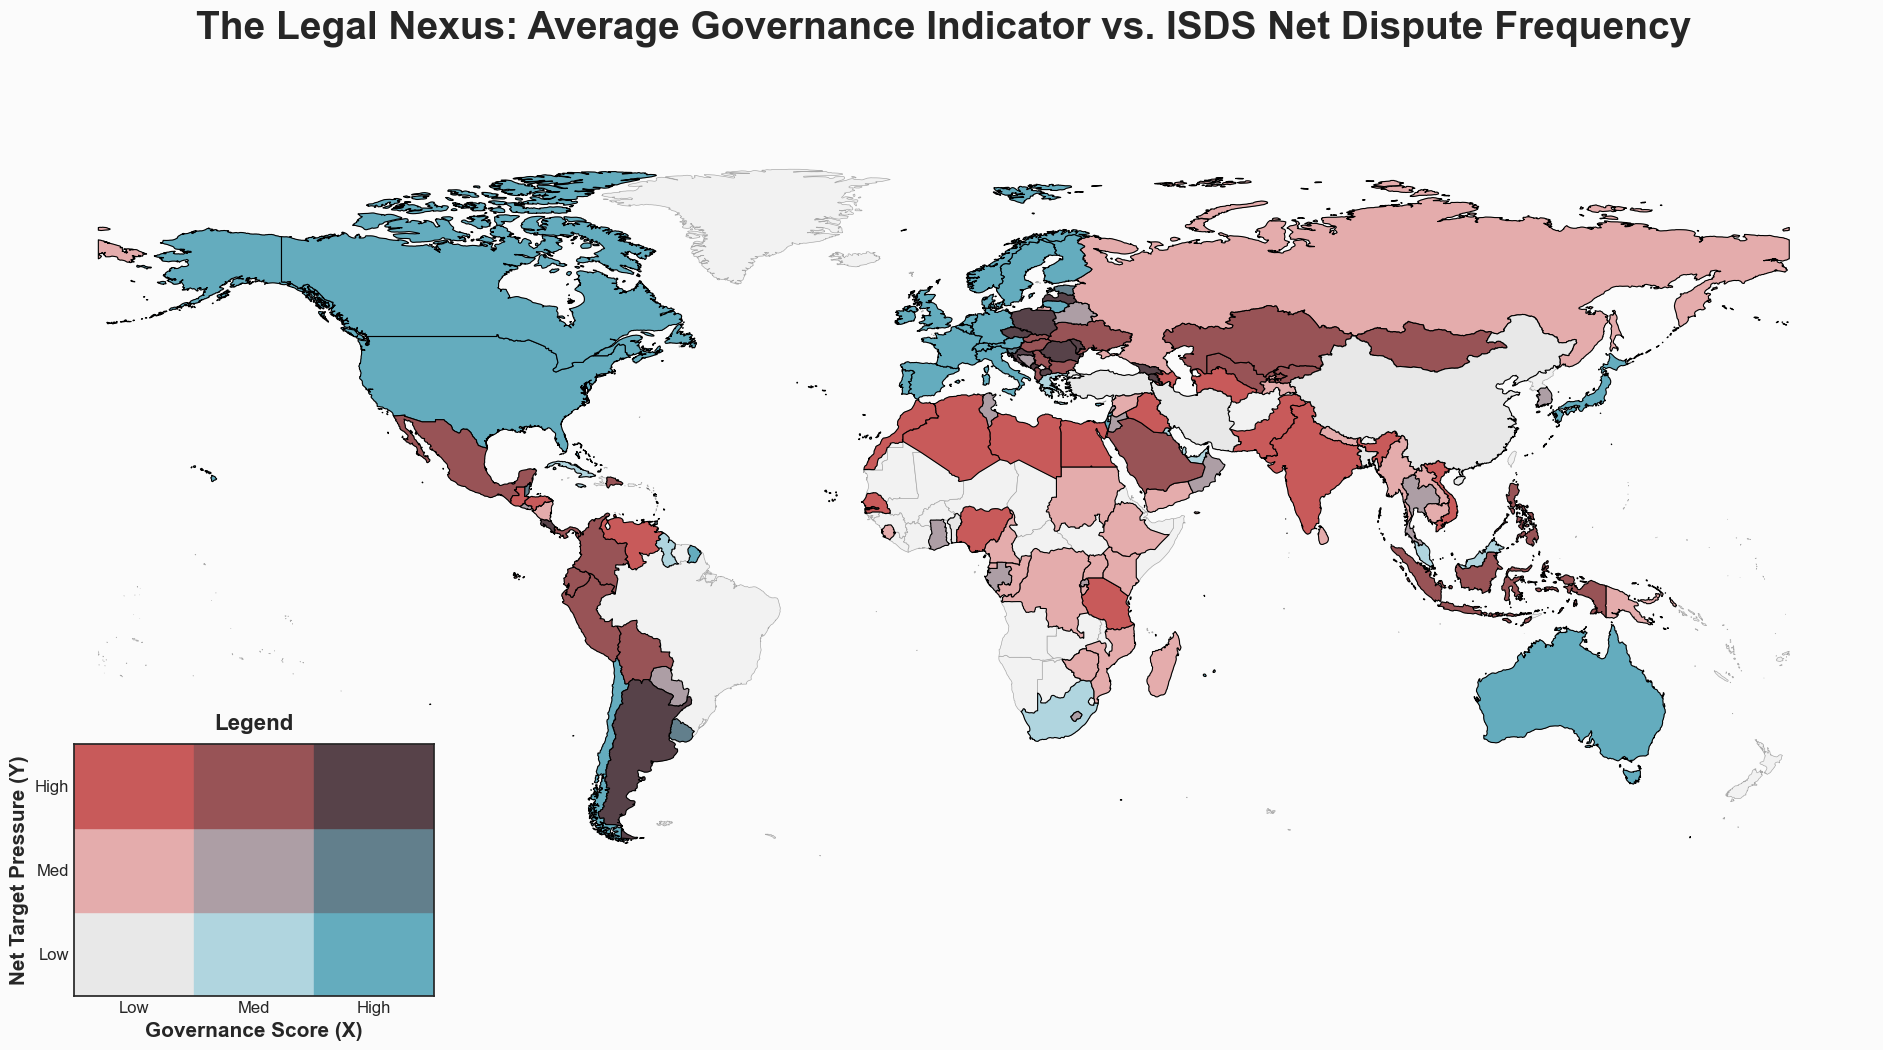

In [96]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# --- 1. SETTINGS & STYLE (Lec 03) ---
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 28,
    "axes.labelsize": 18
})

# Unified Bivariate Color Matrix (X: Governance | Y: Net Balance)
# We want Red/Dark to signify the "Target" Nexus
bivariate_colors = [
    "#e8e8e8", "#b0d5df", "#64acbe", # Low Y (Net): Grey -> Blue
    "#e4acac", "#ad9ea5", "#627f8c", # Med Y
    "#c85a5a", "#985356", "#574249"  # High Y (Net): Red -> Dark (Nexus)
]

def get_bivariate_color(val_x, val_y):
    if pd.isna(val_x) or pd.isna(val_y): return None
    return bivariate_colors[int(val_x + val_y * 3)]

def create_bins(df, column):
    # Lec 04: Quantile classification
    return pd.qcut(df[column].rank(method='first'), 3, labels=[0, 1, 2]).astype(int)

# --- 2. DATA LOADING & NORMALIZATION ---
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# Preprocessing ISOs
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# Normalize Composite Governance (0-1)
cols_to_norm = ['Corruption_Score', 'Press_Freedom_Score', 'Literacy_Rate_Pct']
for col in cols_to_norm:
    min_v, max_v = indep[col].min(), indep[col].max()
    indep[f'{col}_norm'] = (indep[col] - min_v) / (max_v - min_v)

indep['inst_quality_composite'] = indep[[f'{c}_norm' for c in cols_to_norm]].mean(axis=1)

# --- 3. CALCULATE NET ISDS BALANCE ---
isds_trans = isds[isds['inv_iso3'] != isds['resp_iso3']].copy()

inv_counts = isds_trans['inv_iso3'].value_counts().reset_index()
inv_counts.columns = ['iso3', 'investor_count']

resp_counts = isds_trans['resp_iso3'].value_counts().reset_index()
resp_counts.columns = ['iso3', 'respondent_count']

net_df = pd.merge(inv_counts, resp_counts, on='iso3', how='outer').fillna(0)
# NOTE: We use Respondent - Investor so that 'High Y' = Most Heavily Targeted
net_df['net_targeted_pressure'] = net_df['respondent_count'] - net_df['investor_count']

# --- 4. JOINING & BIVARIATE CALCULATION ---
df_biv = indep[['iso3', 'inst_quality_composite']].merge(net_df, on='iso3', how='inner')
df_biv = df_biv.dropna(subset=['inst_quality_composite', 'net_targeted_pressure']).copy()

df_biv['x_bin'] = create_bins(df_biv, 'inst_quality_composite')
df_biv['y_bin'] = create_bins(df_biv, 'net_targeted_pressure')
df_biv['color'] = df_biv.apply(lambda r: get_bivariate_color(r['x_bin'], r['y_bin']), axis=1)

# --- 5. VISUALIZATION ---
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world = world.rename(columns={"ADMIN": "country", "ADM0_A3": "iso3"})[["country", "iso3", "geometry"]]
world = world[world["country"] != "Antarctica"]

fig, ax = plt.subplots(figsize=(24, 14), facecolor='#fbfbfb')

# Background
world.plot(ax=ax, color='#f2f2f2', edgecolor='darkgrey', linewidth=0.5)

# Main Data Layer
map_df = world.merge(df_biv[['iso3', 'color']], on='iso3', how='left')
map_to_plot = map_df.dropna(subset=['color'])
if not map_to_plot.empty:
    map_to_plot.plot(ax=ax, color=map_to_plot['color'], edgecolor='black', linewidth=0.8)

# Title
ax.set_title("The Legal Nexus: Average Governance Indicator vs. ISDS Net Dispute Frequency", 
             fontweight='bold', pad=70, loc='center')

# --- 6. ENLARGED BIVARIATE LEGEND ---
leg_ax = fig.add_axes([0.15, 0.15, 0.15, 0.18]) 
for y in range(3):
    for x in range(3):
        color = bivariate_colors[x + y * 3]
        leg_ax.add_patch(mpatches.Rectangle((x, y), 1, 1, color=color))

leg_ax.set_xlim(0, 3)
leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'], fontsize=12)

leg_ax.set_xlabel('Governance Score (X)', fontsize=15, fontweight='bold')
leg_ax.set_ylabel('Net Target Pressure (Y)', fontsize=15, fontweight='bold')
leg_ax.set_title('Legend', fontsize=16, fontweight='bold', pad=10)
leg_ax.tick_params(length=0)

ax.axis('off')

plt.savefig('net_isds_nexus_bivariate.png', dpi=600, bbox_inches='tight')
plt.show()

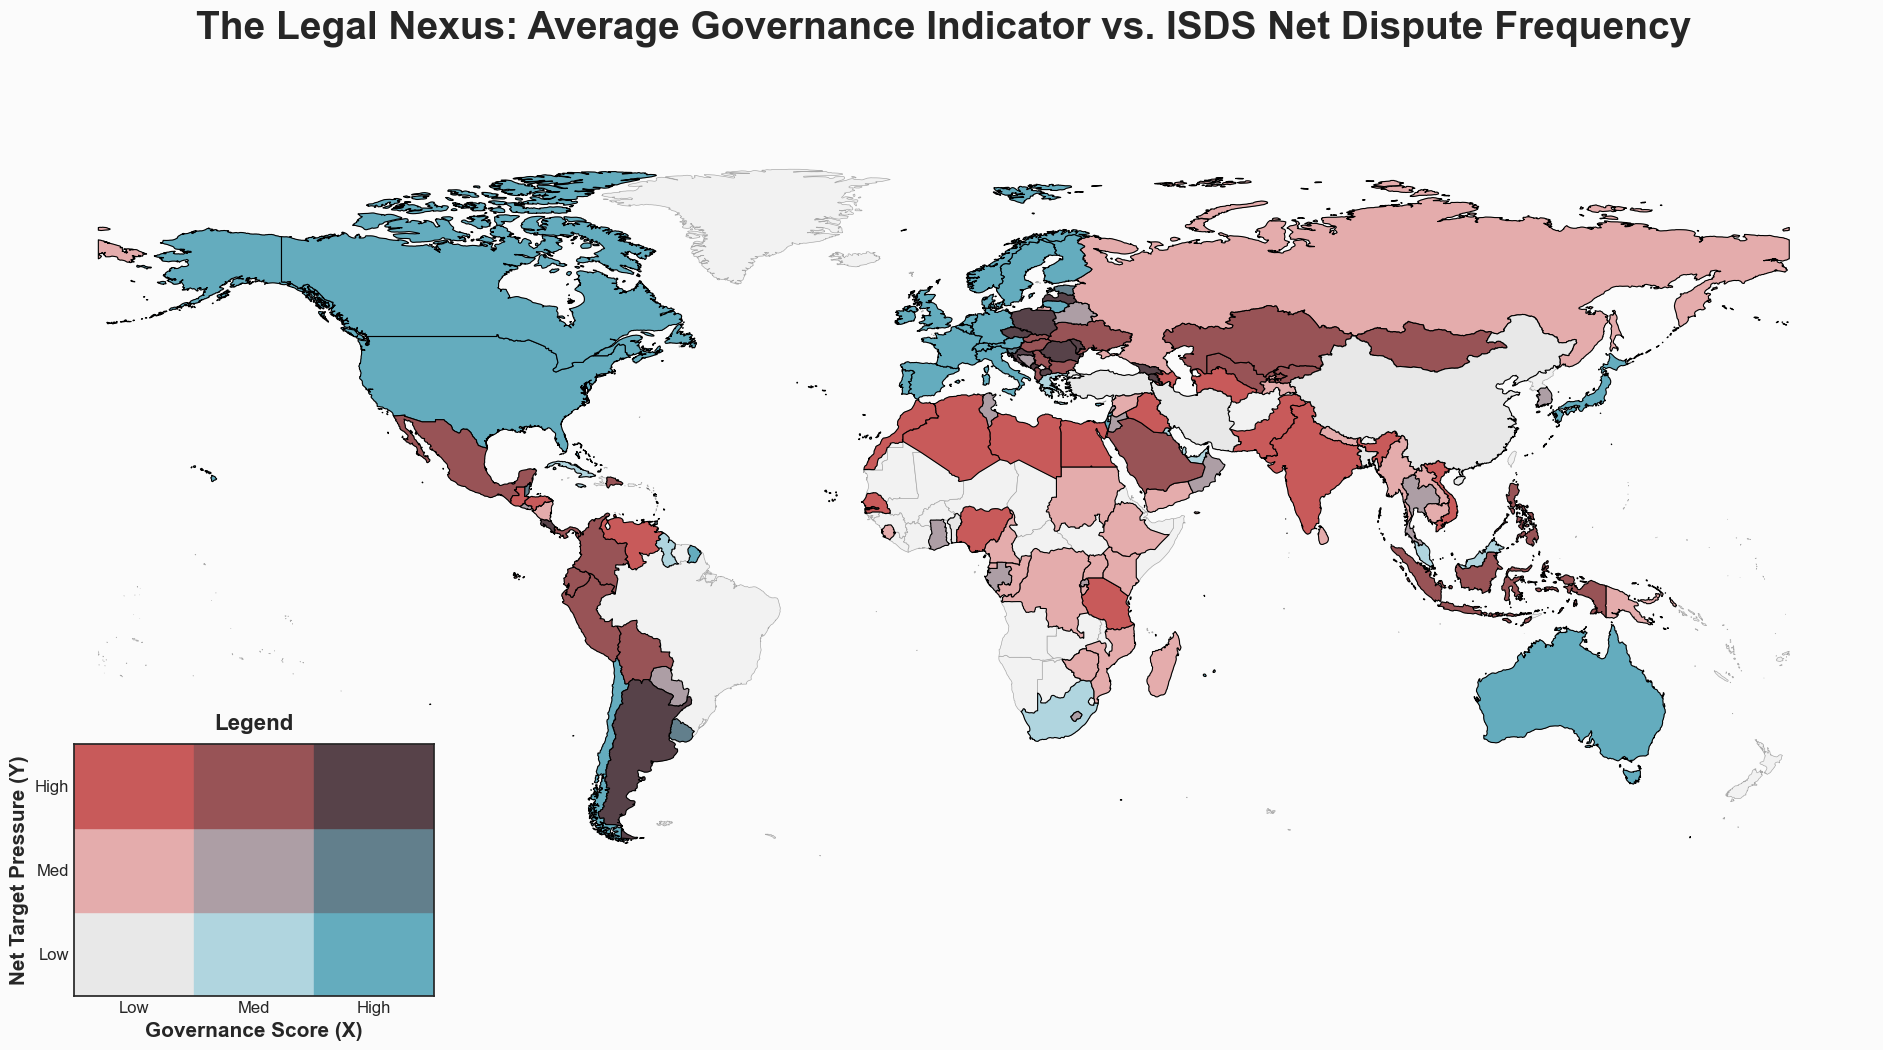

In [95]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# --- 1. SETTINGS & STYLE (Lec 03) ---
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 28,
    "axes.labelsize": 18
})

# Unified Bivariate Color Matrix (X: Governance | Y: Net Balance)
# We want Red/Dark to signify the "Target" Nexus
bivariate_colors = [
    "#e8e8e8", "#b0d5df", "#64acbe", # Low Y (Net): Grey -> Blue
    "#e4acac", "#ad9ea5", "#627f8c", # Med Y
    "#c85a5a", "#985356", "#574249"  # High Y (Net): Red -> Dark (Nexus)
]

def get_bivariate_color(val_x, val_y):
    if pd.isna(val_x) or pd.isna(val_y): return None
    return bivariate_colors[int(val_x + val_y * 3)]

def create_bins(df, column):
    # Lec 04: Quantile classification
    return pd.qcut(df[column].rank(method='first'), 3, labels=[0, 1, 2]).astype(int)

# --- 2. DATA LOADING & NORMALIZATION ---
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# Preprocessing ISOs
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# Normalize Composite Governance (0-1)
cols_to_norm = ['Corruption_Score', 'Press_Freedom_Score', 'Literacy_Rate_Pct']
for col in cols_to_norm:
    min_v, max_v = indep[col].min(), indep[col].max()
    indep[f'{col}_norm'] = (indep[col] - min_v) / (max_v - min_v)

indep['inst_quality_composite'] = indep[[f'{c}_norm' for c in cols_to_norm]].mean(axis=1)

# --- 3. CALCULATE NET ISDS BALANCE ---
isds_trans = isds[isds['inv_iso3'] != isds['resp_iso3']].copy()

inv_counts = isds_trans['inv_iso3'].value_counts().reset_index()
inv_counts.columns = ['iso3', 'investor_count']

resp_counts = isds_trans['resp_iso3'].value_counts().reset_index()
resp_counts.columns = ['iso3', 'respondent_count']

net_df = pd.merge(inv_counts, resp_counts, on='iso3', how='outer').fillna(0)
# NOTE: We use Respondent - Investor so that 'High Y' = Most Heavily Targeted
net_df['net_targeted_pressure'] = net_df['respondent_count'] - net_df['investor_count']

# --- 4. JOINING & BIVARIATE CALCULATION ---
df_biv = indep[['iso3', 'inst_quality_composite']].merge(net_df, on='iso3', how='inner')
df_biv = df_biv.dropna(subset=['inst_quality_composite', 'net_targeted_pressure']).copy()

df_biv['x_bin'] = create_bins(df_biv, 'inst_quality_composite')
df_biv['y_bin'] = create_bins(df_biv, 'net_targeted_pressure')
df_biv['color'] = df_biv.apply(lambda r: get_bivariate_color(r['x_bin'], r['y_bin']), axis=1)

# --- 5. VISUALIZATION ---
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world = world.rename(columns={"ADMIN": "country", "ADM0_A3": "iso3"})[["country", "iso3", "geometry"]]
world = world[world["country"] != "Antarctica"]

fig, ax = plt.subplots(figsize=(24, 14), facecolor='#fbfbfb')

# Background
world.plot(ax=ax, color='#f2f2f2', edgecolor='darkgrey', linewidth=0.5)

# Main Data Layer
map_df = world.merge(df_biv[['iso3', 'color']], on='iso3', how='left')
map_to_plot = map_df.dropna(subset=['color'])
if not map_to_plot.empty:
    map_to_plot.plot(ax=ax, color=map_to_plot['color'], edgecolor='black', linewidth=0.8)

# Title
ax.set_title("The Legal Nexus: Average Governance Indicator vs. ISDS Net Dispute Frequency", 
             fontweight='bold', pad=70, loc='center')

# --- 6. ENLARGED BIVARIATE LEGEND ---
leg_ax = fig.add_axes([0.15, 0.15, 0.15, 0.18]) 
for y in range(3):
    for x in range(3):
        color = bivariate_colors[x + y * 3]
        leg_ax.add_patch(mpatches.Rectangle((x, y), 1, 1, color=color))

leg_ax.set_xlim(0, 3)
leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'], fontsize=12)

leg_ax.set_xlabel('Governance Score', fontsize=15, fontweight='bold')
leg_ax.set_ylabel('Net Target Pressure', fontsize=15, fontweight='bold')
leg_ax.set_title('Legend', fontsize=16, fontweight='bold', pad=10)
leg_ax.tick_params(length=0)

ax.axis('off')

plt.savefig('net_isds_nexus_bivariate.png', dpi=600, bbox_inches='tight')
plt.show()

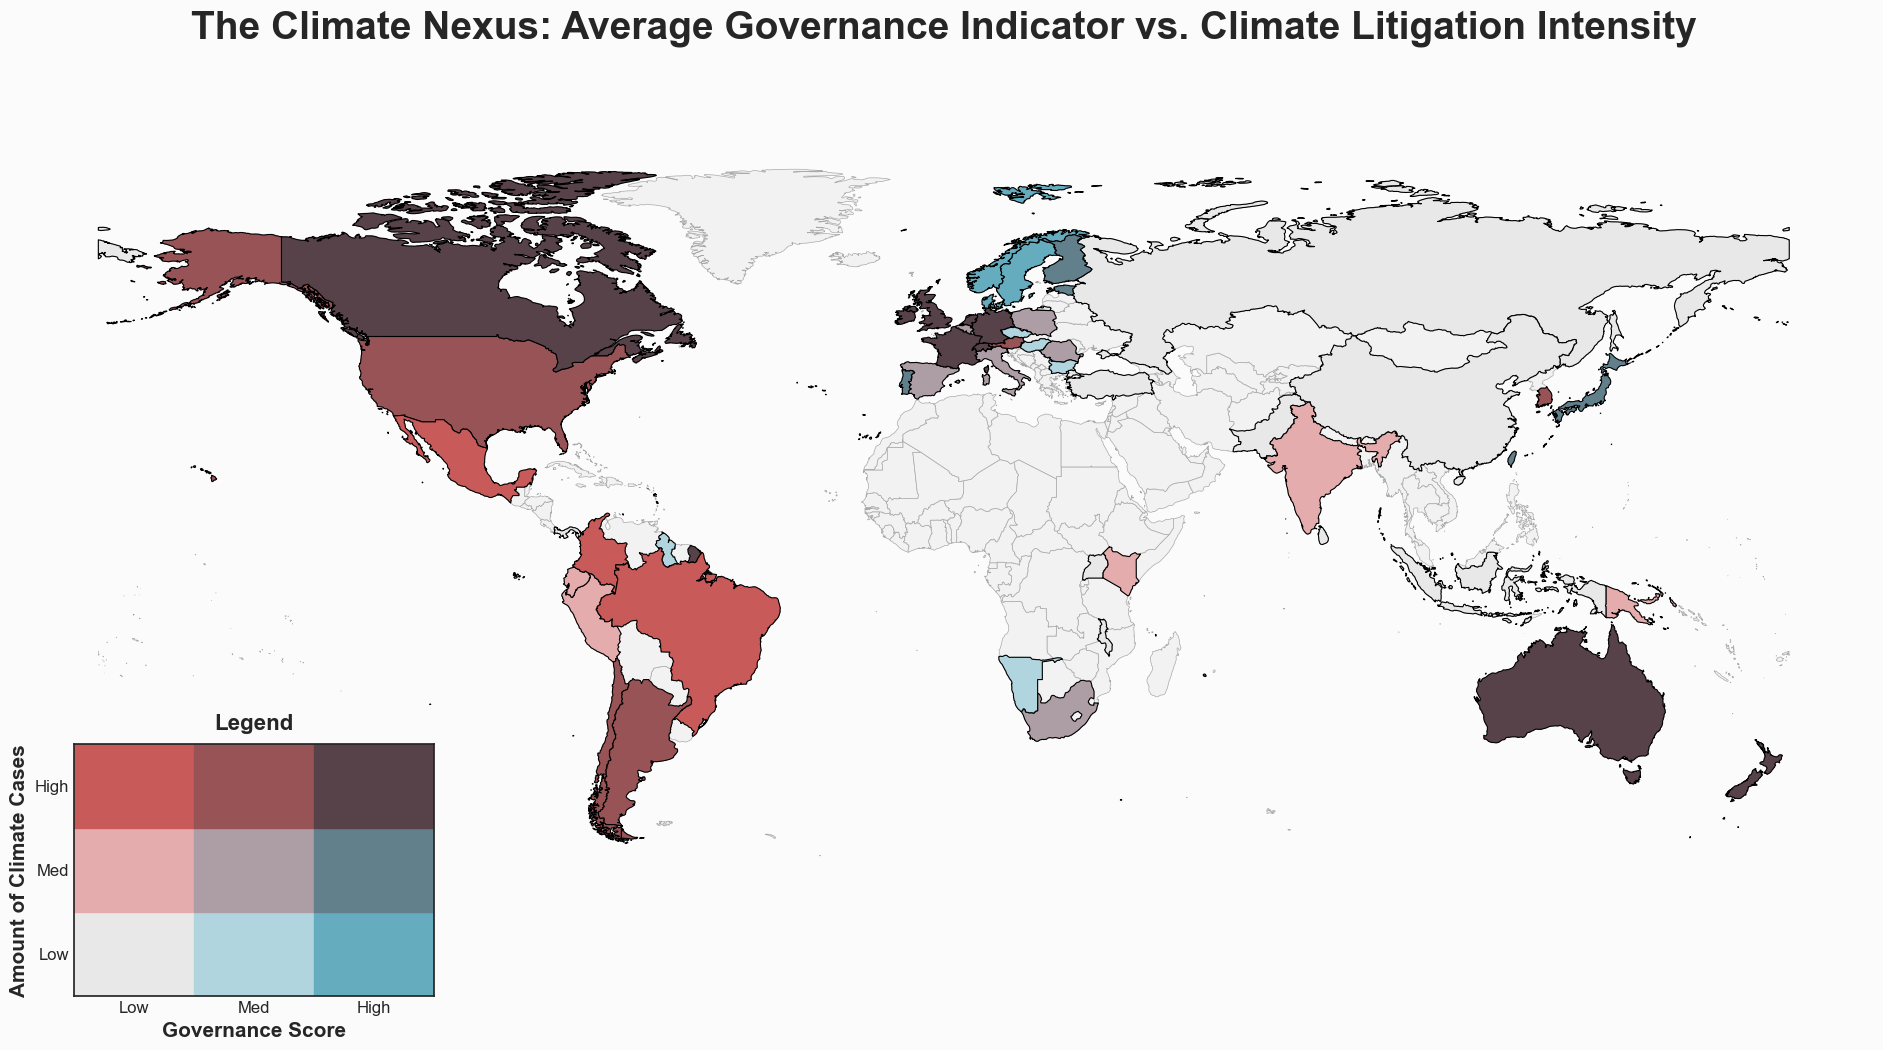

In [98]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# --- 1. SETTINGS & STYLE (Lec 03) ---
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 28,
    "axes.labelsize": 18
})

bivariate_colors = [
    "#e8e8e8", "#b0d5df", "#64acbe", # Low Y: Grey -> Blue
    "#e4acac", "#ad9ea5", "#627f8c", # Med Y
    "#c85a5a", "#985356", "#574249"  # High Y: Red -> Dark (High Vulnerability)
]

def get_bivariate_color(val_x, val_y):
    if pd.isna(val_x) or pd.isna(val_y): return None
    return bivariate_colors[int(val_x + val_y * 3)]

def create_bins(df, column):
    # Lec 04: Quantile classification using ranks (3 bins: Low, Med, High)
    return pd.qcut(df[column].rank(method='first'), 3, labels=[0, 1, 2]).astype(int)

# --- 2. DATA LOADING & PREPARATION ---
climate = pd.read_csv('climate_litigation_final_unified.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# Extract ISO3 from 'Geographies' (First part before semicolon)
climate['iso3'] = climate['Geographies'].str.split(';').str[0].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# --- 3. GOVERNANCE NORMALIZATION ---
# Standardizing the "Institutional Quality" Index (Corruption, Press Freedom, Literacy)
cols_to_norm = ['Corruption_Score', 'Press_Freedom_Score', 'Literacy_Rate_Pct']
for col in cols_to_norm:
    min_val, max_val = indep[col].min(), indep[col].max()
    indep[f'{col}_norm'] = (indep[col] - min_val) / (max_val - min_val)

norm_cols = [f'{col}_norm' for col in cols_to_norm]
indep['inst_quality_composite'] = indep[norm_cols].mean(axis=1)

# --- 4. LITIGATION INTENSITY ---
# Count cases per country
lit_intensity = climate.groupby('iso3').size().reset_index(name='case_count')

# Merge and clean
df_biv = indep[['iso3', 'inst_quality_composite']].merge(lit_intensity, on='iso3', how='inner')
df_biv = df_biv.dropna(subset=['inst_quality_composite', 'case_count']).copy()

# Calculate Bivariate Bins and Colors
df_biv['x_bin'] = create_bins(df_biv, 'inst_quality_composite')
df_biv['y_bin'] = create_bins(df_biv, 'case_count')
df_biv['color'] = df_biv.apply(lambda r: get_bivariate_color(r['x_bin'], r['y_bin']), axis=1)

# --- 5. VISUALIZATION ---
world_url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(world_url)
world = world.rename(columns={"ADMIN": "country", "ADM0_A3": "iso3"})[["country", "iso3", "geometry"]]
world = world[world["country"] != "Antarctica"]

fig, ax = plt.subplots(figsize=(24, 14), facecolor='#fbfbfb')

# Background layer
world.plot(ax=ax, color='#f2f2f2', edgecolor='darkgrey', linewidth=0.5)

# Main Data layer with black borders
map_df = world.merge(df_biv[['iso3', 'color']], on='iso3', how='left')
map_to_plot = map_df.dropna(subset=['color'])

if not map_to_plot.empty:
    map_to_plot.plot(ax=ax, color=map_to_plot['color'], edgecolor='black', linewidth=0.8)

# Title
ax.set_title("The Climate Nexus: Average Governance Indicator vs. Climate Litigation Intensity", 
             fontweight='bold', pad=70, loc='center')

# Bivariate Legend (Enlarged per your previous style)
leg_ax = fig.add_axes([0.15, 0.15, 0.15, 0.18]) 
for y in range(3):
    for x in range(3):
        color = bivariate_colors[x + y * 3]
        leg_ax.add_patch(mpatches.Rectangle((x, y), 1, 1, color=color))

leg_ax.set_xlim(0, 3); leg_ax.set_ylim(0, 3)
leg_ax.set_xticks([0.5, 1.5, 2.5]); leg_ax.set_xticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_yticks([0.5, 1.5, 2.5]); leg_ax.set_yticklabels(['Low', 'Med', 'High'], fontsize=12)
leg_ax.set_xlabel('Governance Score', fontsize=15, fontweight='bold')
leg_ax.set_ylabel('Amount of Climate Cases', fontsize=15, fontweight='bold')
leg_ax.set_title('Legend', fontsize=16, fontweight='bold', pad=10)
leg_ax.tick_params(length=0)

ax.axis('off')

plt.savefig('climate_nexus_bivariate.png', dpi=600, bbox_inches='tight')
plt.show()

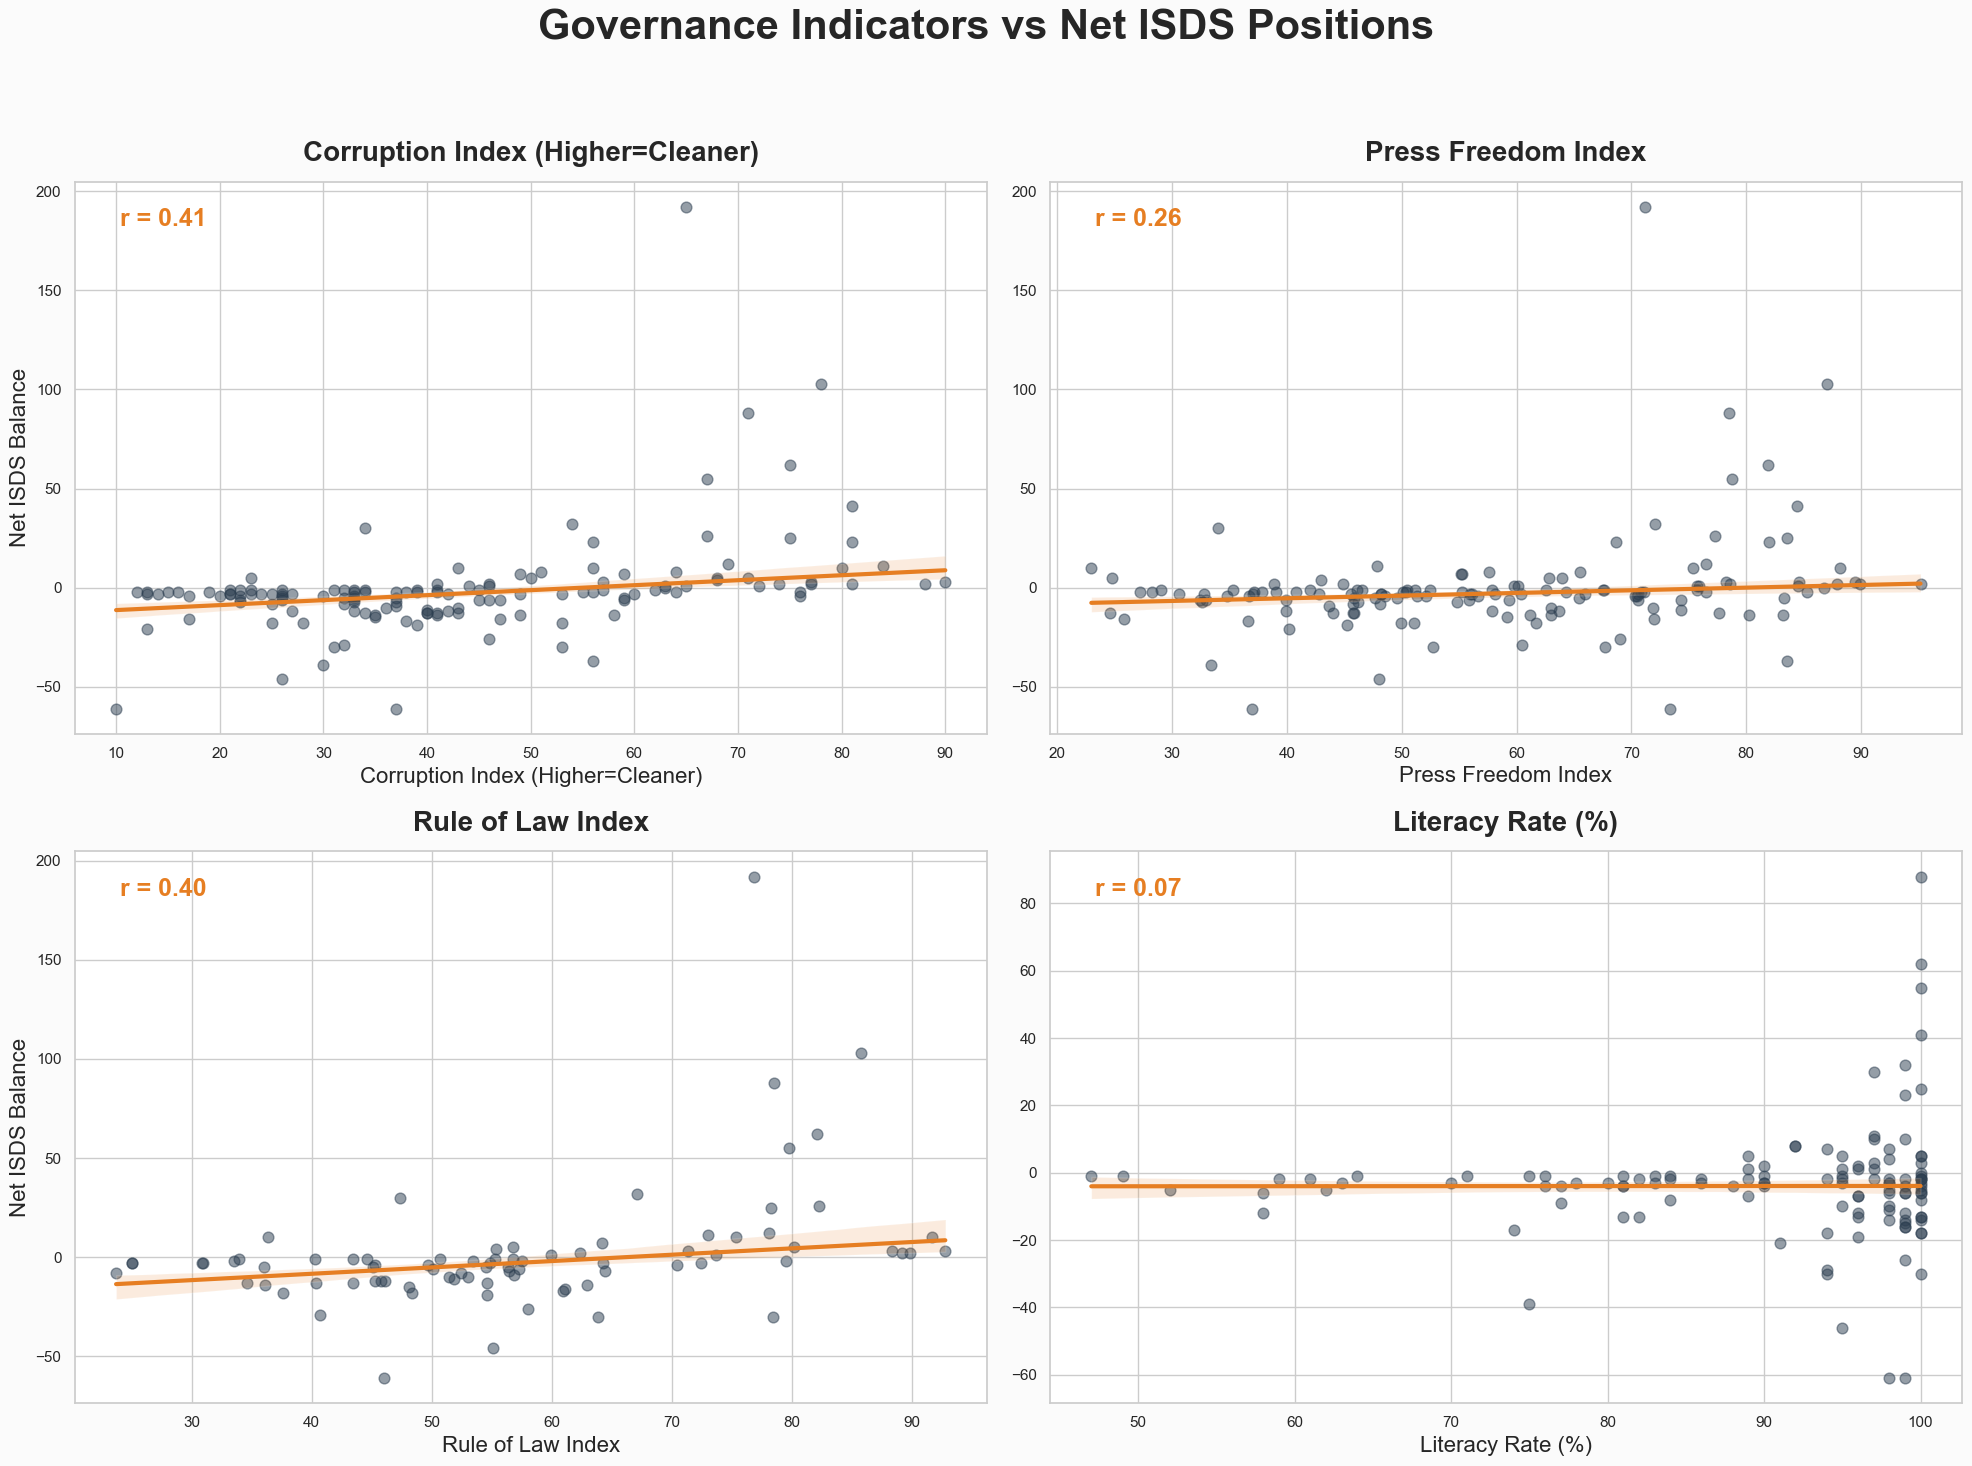

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. LOAD DATA
isds = pd.read_csv('ISDS_processed_dataset_final.csv')
indep = pd.read_csv('combined_independent_variables.csv')

# 2. STANDARDIZE ISO CODES
isds['inv_iso3'] = isds['investor_home_state_iso3'].str.strip().str.upper()
isds['resp_iso3'] = isds['respondent_state_iso3'].str.strip().str.upper()
indep['iso3'] = indep['ISO3'].str.strip().str.upper()

# 3. CALCULATE NET ISDS DISPUTES (TRANSNATIONAL)
isds_trans = isds[isds['inv_iso3'] != isds['resp_iso3']].copy()

inv_counts = isds_trans['inv_iso3'].value_counts().reset_index()
inv_counts.columns = ['iso3', 'investor_count']

resp_counts = isds_trans['resp_iso3'].value_counts().reset_index()
resp_counts.columns = ['iso3', 'respondent_count']

# Combine counts and calculate Net (Investor - Respondent)
net_df = pd.merge(inv_counts, resp_counts, on='iso3', how='outer').fillna(0)
net_df['net_isds'] = net_df['investor_count'] - net_df['respondent_count']

# 4. SETUP 2x2 PLOTS FOR 4 DIFFERENT GOVERNANCE INDICATORS
indicators = [
    ('Corruption_Score', 'Corruption Index (Higher=Cleaner)'),
    ('Press_Freedom_Score', 'Press Freedom Index'),
    ('Rule_of_Law_Score_Pct', 'Rule of Law Index'),
    ('Literacy_Rate_Pct', 'Literacy Rate (%)') # Added Literacy Rate
]

fig, axes = plt.subplots(2, 2, figsize=(20, 15), facecolor='#fbfbfb')
axes = axes.flatten()
sns.set_style("whitegrid")

for i, (col, label) in enumerate(indicators):
    ax = axes[i]
    
    # Merge Net ISDS with specific governance column
    # Inner join automatically handles the "missing country" issue by excluding them
    merged = pd.merge(net_df[['iso3', 'net_isds']], indep[['iso3', col]], on='iso3', how='inner')
    merged = merged.dropna(subset=[col, 'net_isds'])
    
    # Regression Plot
    sns.regplot(
        data=merged, 
        x=col, 
        y='net_isds', 
        ax=ax,
        scatter_kws={'alpha':0.5, 'color':'#2c3e50', 's':60},
        line_kws={'color':'#e67e22', 'lw':3}, # Orange trend line
        robust=True 
    )
    
    # Labeling & Correlation Coefficient
    ax.set_title(label, fontsize=20, fontweight='bold', pad=15)
    ax.set_xlabel(label, fontsize=16)
    ax.set_ylabel("Net ISDS Balance" if i % 2 == 0 else "", fontsize=16)
    
    # Statistical Context
    corr = merged[col].corr(merged['net_isds'])
    ax.text(0.05, 0.92, f'r = {corr:.2f}', transform=ax.transAxes, 
            fontsize=18, fontweight='bold', color='#e67e22')

plt.suptitle("Governance Indicators vs Net ISDS Positions", 
             fontsize=30, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('isds_net_governance_quad_analysis.png', dpi=600, bbox_inches='tight')
plt.show()

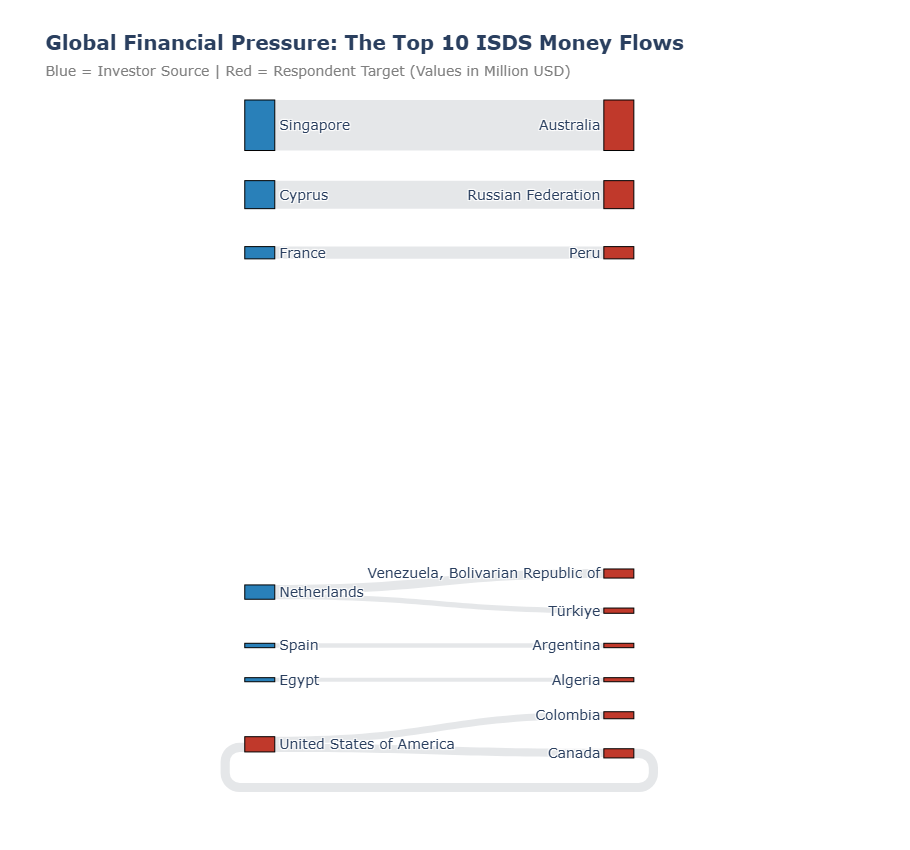

In [117]:
import pandas as pd
import plotly.graph_objects as go

# 1. LOAD DATA
isds = pd.read_csv('ISDS_processed_dataset_final.csv')

# 2. PREPARE DATA
# Columns based on your dataset: 'investor_home_state', 'respondent_state', 'amount_claimed_musd'
inv_col = 'investor_home_state'      
resp_col = 'respondent_state'       
money_col = 'amount_claimed_musd'    

# Filter for transnational cases and clean missing values
df_flow = isds[isds['investor_home_state_iso3'] != isds['respondent_state_iso3']].copy()
df_flow = df_flow.dropna(subset=[money_col])

# Aggregate the Top 10 flows by volume
flow_agg = df_flow.groupby([inv_col, resp_col])[money_col].sum().reset_index()
top_10 = flow_agg.nlargest(10, money_col)

# 3. DEFINE NODES & COLORS
# We separate sources and targets to assign distinct colors
sources_list = list(top_10[inv_col].unique())
targets_list = list(top_10[resp_col].unique())

# Combined list for indexing
all_nodes = sources_list + targets_list
node_indices = {name: i for i, name in enumerate(all_nodes)}

# Color Story: Blue for the 'Suing' countries, Red for the 'Sued' countries
node_colors = ["#2980b9"] * len(sources_list) + ["#c0392b"] * len(targets_list)

# 4. MAP FLOWS
sources_idx = [node_indices[src] for src in top_10[inv_col]]
targets_idx = [node_indices[tgt] for tgt in top_10[resp_col]]
values = top_10[money_col].tolist()

# 5. CONSTRUCT THE DIAGRAM
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=30,           # Space between nodes to prevent overlap
        thickness=30,     # Width of the vertical bars
        line=dict(color="black", width=1),
        label=all_nodes,
        color=node_colors # Blue sources, Red targets
    ),
    link=dict(
        source=sources_idx,
        target=targets_idx,
        value=values,
        color="rgba(189, 195, 199, 0.4)", # Subtle grey for the "flow pipeline"
        hovertemplate='<b>%{source.label}</b> claims <b>$ %{value:,.1f}M</b> from <b>%{target.label}</b><extra></extra>'
    )
)])

# 6. OPTIMIZE LAYOUT FOR VISIBILITY
fig.update_layout(
    title=dict(
        text="<b>Global Financial Pressure: The Top 10 ISDS Money Flows</b><br>" + 
             "<span style='font-size:14px; color:gray'>Blue = Investor Source | Red = Respondent Target (Values in Million USD)</span>",
        x=0.05,
        xanchor='left'
    ),
    font_size=14,
    width=1300,   # Wide enough to accommodate long country names
    height=850,   # Tall enough to separate the 10 paths clearly
    margin=dict(l=200, r=200, t=100, b=50), # Large margins to prevent label clipping
    template="plotly_white"
)

# 7. SHOW & SAVE
# If you are in a Jupyter Notebook and it's still cut off, run this line:
fig.show(renderer="iframe") 

# Alternatively, save to HTML to open it in a full-screen browser window:
fig.write_html("isds_money_flow_sankey.html")
fig.show()